In [1]:
import pandas as pd
import numpy as np

sampled_data = pd.read_parquet("sampled_simulations_5th.parquet")

In [2]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import GroupKFold, GroupShuffleSplit
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

# Add normalized time to the features
def normalize_time_per_simulation(df, simulation_column, time_column):
    # Normalize time for each simulation
    df['Normalized_Time'] = df.groupby(simulation_column)[time_column].transform(lambda x: x / x.max())
    return df

# Apply the function to normalize time
sampled_data = normalize_time_per_simulation(sampled_data, simulation_column='Simulation_ID', time_column='Time (s)')

# Update features (X) to include normalized time
X = sampled_data.drop(columns=['Simulation_ID', 'Time (s)', 
                               '5nm_retentate', '5nm_permeate', '5nm_cumulative_yield', '5nm_size_solute',
                               '40nm_retentate', '40nm_permeate', '40nm_cumulative_yield', '40nm_size_solute',
                               '70nm_retentate', '70nm_permeate', '70nm_cumulative_yield', '70nm_size_solute',
                               '120nm_retentate', '120nm_permeate', '120nm_cumulative_yield', '120nm_size_solute',
                               '190nm_retentate', '190nm_permeate', '190nm_cumulative_yield', '190nm_size_solute',
                               '300nm_retentate', '300nm_permeate', '300nm_cumulative_yield', '300nm_size_solute',
                               '700nm_retentate', '700nm_permeate', '700nm_cumulative_yield', '700nm_size_solute',
                               '2500nm_retentate', '2500nm_permeate', '2500nm_cumulative_yield', '2500nm_size_solute',
                               'Diavolumes'])


Y = sampled_data[['5nm_retentate', '5nm_permeate',
                  '40nm_retentate', '40nm_permeate', 
                  '70nm_retentate', '70nm_permeate',   
                  '120nm_retentate', '120nm_permeate',  
                  '190nm_retentate', '190nm_permeate', 
                  '300nm_retentate', '300nm_permeate', 
                  '700nm_retentate', '700nm_permeate', 
                  '2500nm_retentate', '2500nm_permeate',
                  'Diavolumes']]
# Add normalized time to the features

groups = sampled_data['Simulation_ID']

# Define the number of components for PLS


# Split data into train-validation and test sets
group_split = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

In [ ]:

train_val_idx, test_idx = next(group_split.split(X, Y, groups))
n_components = 6
X_train_val, X_test = X[train_val_idx], X[test_idx]
Y_train_val, Y_test = Y [train_val_idx], Y.iloc[test_idx]
groups_train_val = groups.iloc[train_val_idx]

# Initialize scalers
feature_scaler = StandardScaler()
# target_scaler = StandardScaler()

# Set up 5-fold cross-validation
n_folds = 5  # Use optimal number of splits from previous step
group_kfold = GroupKFold(n_splits=n_folds)

# Initialize placeholders for aggregate metrics
validation_q2_list, validation_r2_list = [], []
validation_mae_list = []
validation_mse_list, validation_rmse_list = [], []


for fold, (train_idx, val_idx) in enumerate(group_kfold.split(X_train_val, Y_train_val, groups_train_val), start=1):
    # Split into train and validation sets for this fold
    X_train_fold, X_val_fold = X_train_val.iloc[train_idx], X_train_val.iloc[val_idx]
    Y_train_fold, Y_val_fold = Y_train_val.iloc[train_idx], Y_train_val.iloc[val_idx]

    # Scale train and validation data
    X_train_fold_scaled = feature_scaler.fit_transform(X_train_fold)
    # Y_train_fold_scaled = target_scaler.fit_transform(Y_train_fold)

    X_val_fold_scaled = feature_scaler.transform(X_val_fold)
    # Y_val_fold_scaled = target_scaler.transform(Y_val_fold)

    # Train PLS model
    pls_model_simple = PLSRegression(n_components=n_components)
    pls_model_simple.fit(X_train_fold_scaled, Y_train_fold)

    # Predict on validation set
    Y_val_pred = pls_model_simple.predict(X_val_fold_scaled)
    # Y_val_pred = target_scaler.inverse_transform(Y_val_pred_scaled)
    # Y_val_actual = target_scaler.inverse_transform(Y_val_fold)
 # Compute metrics for validation set
    val_mse = mean_squared_error(Y_val_fold, Y_val_pred, multioutput='raw_values')
    val_rmse = np.sqrt(val_mse)
    val_r2 = r2_score(Y_val_fold, Y_val_pred, multioutput='uniform_average')
    val_mae = mean_absolute_error(Y_val_fold, Y_val_pred, multioutput='raw_values')
    train_mean = Y_train_fold.mean(axis=0)  # Mean of the training set
    val_q2 = 1 - (np.sum((Y_val_fold - Y_val_pred) ** 2, axis=0) /
                  np.sum((Y_val_fold - train_mean) ** 2, axis=0))
    val_q2 = np.mean(val_q2)  # Average Q² across all targets

    # Aggregate metrics across folds
    validation_q2_list.append(val_q2)
    validation_r2_list.append(val_r2)
    validation_mae_list.append(np.mean(val_mae))
    validation_mse_list.append(np.mean(val_mse))
    validation_rmse_list.append(np.mean(val_rmse))

# Compute averages across all folds for validation
avg_val_q2 = np.mean(validation_q2_list)
avg_val_r2 = np.mean(validation_r2_list)
avg_val_mae = np.mean(validation_mae_list)
avg_val_mse = np.mean(validation_mse_list)
avg_val_rmse = np.mean(validation_rmse_list)

# Print validation results
print(f"\nValidation Results (Averaged Across Folds):")
print(f"  Q²: {avg_val_q2:.7f}")
print(f"  R²: {avg_val_r2:.7f}")
print(f"  MAE: {avg_val_mae:.7f}")
print(f"  MSE: {avg_val_mse:.7f}")
print(f"  RMSE: {avg_val_rmse:.7f}")

# Compute metrics per target for validation
print("\nValidation Metrics Per Target:")
for i, target in enumerate(Y.columns):
    target_val_r2 = r2_score(Y_val_fold.iloc[:, i], Y_val_pred[:, i])
    target_val_mse = mean_squared_error(Y_val_fold.iloc[:, i], Y_val_pred[:, i])
    target_val_rmse = np.sqrt(target_val_mse)
    target_val_mae = mean_absolute_error(Y_val_fold.iloc[:, i], Y_val_pred[:, i])
    target_val_q2 = 1 - (
        np.sum((Y_val_fold.iloc[:, i] - Y_val_pred[:, i]) ** 2) /
        np.sum((Y_val_fold.iloc[:, i] - np.mean(Y_val_fold.iloc[:, i])) ** 2)
    )
    print(f"Target: {target}")
    print(f"  R²: {target_val_r2:.7f}")
    print(f"  Q²: {target_val_q2:.7f}")
    print(f"  MAE: {target_val_mae:.7f}")
    print(f"  MSE: {target_val_mse:.7f}")
    print(f"  RMSE: {target_val_rmse:.7f}")

X_test_scaled = feature_scaler.transform(X_test)

# Evaluate on test set
Y_test_pred = pls_model_simple.predict(X_test_scaled)

# Compute metrics for test set
test_mse = mean_squared_error(Y_test, Y_test_pred, multioutput='raw_values')
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(Y_test, Y_test_pred, multioutput='uniform_average')
test_mae = mean_absolute_error(Y_test, Y_test_pred, multioutput='raw_values')


# Print test results
print(f"\nTest Results:")
print(f"  R²: {test_r2:.7f}")
print(f"  MAE: {np.mean(test_mae):.7f}")
print(f"  MSE: {np.mean(test_mse):.7f}")
print(f"  RMSE: {np.mean(test_rmse):.7f}")

# Compute metrics per target for test
print("\nTest Metrics Per Target:")
for i, target in enumerate(Y.columns):
    target_test_r2 = r2_score(Y_test.iloc[:, i], Y_test_pred[:, i])
    target_test_mse = mean_squared_error(Y_test.iloc[:, i], Y_test_pred[:, i])
    target_test_rmse = np.sqrt(target_test_mse)
    target_test_mae = mean_absolute_error(Y_test.iloc[:, i], Y_test_pred[:, i])
  

    print(f"Target: {target}")
    print(f"  R²: {target_test_r2:.7f}")
    
    print(f"  MAE: {target_test_mae:.7f}")
    print(f"  MSE: {target_test_mse:.7f}")
    print(f"  RMSE: {target_test_rmse:.7f}")




Validation Results (Averaged Across Folds):
  Q²: 0.7125309
  R²: 0.7292648
  MAE: 0.0202621
  MSE: 0.0120353
  RMSE: 0.0266843

Validation Metrics Per Target:
Target: 5nm_retentate
  R²: 0.6573889
  Q²: 0.6573889
  MAE: 0.0000877
  MSE: 0.0000000
  RMSE: 0.0001086
Target: 5nm_permeate
  R²: 0.6946770
  Q²: 0.6946770
  MAE: 0.0000149
  MSE: 0.0000000
  RMSE: 0.0000182
Target: 40nm_retentate
  R²: 0.7372112
  Q²: 0.7372112
  MAE: 0.0001208
  MSE: 0.0000000
  RMSE: 0.0001486
Target: 40nm_permeate
  R²: 0.6669299
  Q²: 0.6669299
  MAE: 0.0000203
  MSE: 0.0000000
  RMSE: 0.0000247
Target: 70nm_retentate
  R²: 0.7897804
  Q²: 0.7897804
  MAE: 0.0003017
  MSE: 0.0000001
  RMSE: 0.0003803
Target: 70nm_permeate
  R²: 0.5553756
  Q²: 0.5553756
  MAE: 0.0000497
  MSE: 0.0000000
  RMSE: 0.0000622
Target: 120nm_retentate
  R²: 0.8722779
  Q²: 0.8722779
  MAE: 0.0002227
  MSE: 0.0000001
  RMSE: 0.0002865
Target: 120nm_permeate
  R²: 0.4998075
  Q²: 0.4998075
  MAE: 0.0000352
  MSE: 0.0000000
  RMS

/var/folders/x1/1094qf1d4c1g3_6s3f1qxk_h0000gn/T/ipykernel_1355/2540910843.py:81: RuntimeWarning: invalid value encountered in scalar divide
  np.sum((Y_val_fold.iloc[:, i] - Y_val_pred[:, i]) ** 2) /


Target: Diavolumes
  R²: 0.6159778
  Q²: 0.6159778
  MAE: 0.3478550
  MSE: 0.2107063
  RMSE: 0.4590276

Test Results:
  R²: 0.7314358
  MAE: 0.0202598
  MSE: 0.0120220
  RMSE: 0.0266704

Test Metrics Per Target:
Target: 5nm_retentate
  R²: 0.6630186
  MAE: 0.0000853
  MSE: 0.0000000
  RMSE: 0.0001054
Target: 5nm_permeate
  R²: 0.7036102
  MAE: 0.0000144
  MSE: 0.0000000
  RMSE: 0.0000176
Target: 40nm_retentate
  R²: 0.7311429
  MAE: 0.0001209
  MSE: 0.0000000
  RMSE: 0.0001491
Target: 40nm_permeate
  R²: 0.6615300
  MAE: 0.0000202
  MSE: 0.0000000
  RMSE: 0.0000248
Target: 70nm_retentate
  R²: 0.7877605
  MAE: 0.0003017
  MSE: 0.0000001
  RMSE: 0.0003782
Target: 70nm_permeate
  R²: 0.5521041
  MAE: 0.0000494
  MSE: 0.0000000
  RMSE: 0.0000619
Target: 120nm_retentate
  R²: 0.8749956
  MAE: 0.0002196
  MSE: 0.0000001
  RMSE: 0.0002797
Target: 120nm_permeate
  R²: 0.5059434
  MAE: 0.0000345
  MSE: 0.0000000
  RMSE: 0.0000447
Target: 190nm_retentate
  R²: 0.9456502
  MAE: 0.0000801
  MSE: 

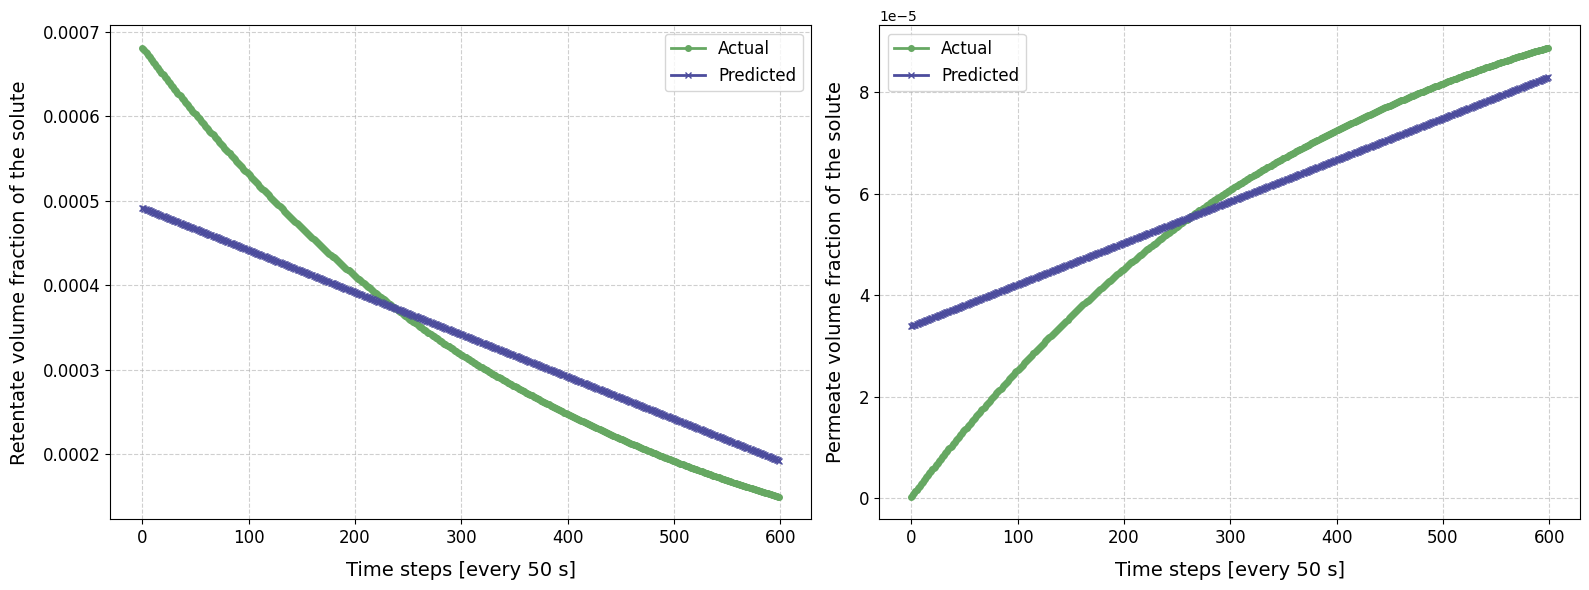

In [ ]:
import random
import matplotlib.pyplot as plt

# Select a random simulation ID from the test set
random_sim_id = random.choice(groups.iloc[test_idx].unique())

# Filter the test data for the selected simulation
X_simulation = X_test[groups.iloc[test_idx] == random_sim_id ]
Y_simulation = Y_test[groups.iloc[test_idx] == random_sim_id ]

# Scale the inputs for prediction
X_simulation_scaled = feature_scaler.transform(X_simulation)

# Predict for the chosen simulation
Y_simulation_pred = pls_model_simple.predict(X_simulation_scaled)


# Convert to DataFrame for easier handling
Y_simulation_actual_df = pd.DataFrame(Y_simulation.values, columns=Y.columns)
Y_simulation_pred_df = pd.DataFrame(Y_simulation_pred, columns=Y.columns)

# Choose a single target
target_name = '5nm_permeate'  # Replace with your desired target
Y_actual_1 = Y_simulation_actual_df[target_name]
Y_pred_1 = Y_simulation_pred_df[target_name]

target_name_2 = '5nm_retentate'  # Replace with your desired target
Y_actual = Y_simulation_actual_df[target_name_2]
Y_pred = Y_simulation_pred_df[target_name_2]

# Create a figure with one row and two columns
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot for retentate (first column)
axes[0].plot(Y_actual.values, label='Actual', marker='o', color='#66a862', linewidth=2, markersize=4)
axes[0].plot(Y_pred.values, label='Predicted', marker='x', color='#4C4C9D', linewidth=2, markersize=4)
# axes[0].set_title(f"Retentate: Predicted vs Actual\nSimulation ID: {random_sim_id}", fontsize=14)
axes[0].set_xlabel('Time steps [every 50 s]', fontsize=14, labelpad=10)
axes[0].set_ylabel('Retentate volume fraction of the solute', fontsize=14, labelpad=10)
axes[0].legend(fontsize=12, loc='best')
axes[0].grid(True, linestyle='--', alpha=0.6)
axes[0].tick_params(axis='both', which='major', labelsize=12)

# Plot for permeate (second column)
axes[1].plot(Y_actual_1.values, label='Actual', marker='o', color='#66a862', linewidth=2, markersize=4)
axes[1].plot(Y_pred_1.values, label='Predicted', marker='x', color='#4C4C9D', linewidth=2, markersize=4)
# axes[1].set_title(f"Permeate: Predicted vs Actual\nSimulation ID: {random_sim_id}", fontsize=14)
axes[1].set_xlabel('Time steps [every 50 s]', fontsize=14, labelpad=10)
axes[1].set_ylabel('Permeate volume fraction of the solute', fontsize=14, labelpad=10)
axes[1].legend(fontsize=12, loc='best')
axes[1].grid(True, linestyle='--', alpha=0.6)
axes[1].tick_params(axis='both', which='major', labelsize=12)

# Tight layout for better spacing
plt.tight_layout()

# Save the figure as a high-resolution image

plt.savefig('retentate_permeate_comparison_simple.png' ,dpi=300)


# Show the plot
plt.show()



In [ ]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import GroupKFold, GroupShuffleSplit
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

# # Add normalized time to the features
# def normalize_time_per_simulation(df, simulation_column, time_column):
#     df['Normalized_Time'] = df.groupby(simulation_column)[time_column].transform(lambda x: x / x.max())
#     return df

# # Apply the function to normalize time
# sampled_data = normalize_time_per_simulation(sampled_data, simulation_column='Simulation_ID', time_column='Time (s)')

# Define features and targets
# X = sampled_data.drop(columns=['Simulation_ID', 'Time (s)', 
#                                '5nm_retentate', '5nm_permeate', '5nm_cumulative_yield', '5nm_size_solute',
#                                '40nm_retentate', '40nm_permeate', '40nm_cumulative_yield', '40nm_size_solute',
#                                '70nm_retentate', '70nm_permeate', '70nm_cumulative_yield', '70nm_size_solute',
#                                '120nm_retentate', '120nm_permeate', '120nm_cumulative_yield', '120nm_size_solute',
#                                '190nm_retentate', '190nm_permeate', '190nm_cumulative_yield', '190nm_size_solute',
#                                '300nm_retentate', '300nm_permeate', '300nm_cumulative_yield', '300nm_size_solute',
#                                '700nm_retentate', '700nm_permeate', '700nm_cumulative_yield', '700nm_size_solute',
#                                '2500nm_retentate', '2500nm_permeate', '2500nm_cumulative_yield', '2500nm_size_solute',
#                                'Diavolumes'])

# Apply log transformation to all features
X_log= np.log1p(X)

# # Define target variables
# Y = sampled_data[['5nm_retentate', '5nm_permeate',
#                   '40nm_retentate', '40nm_permeate', 
#                   '70nm_retentate', '70nm_permeate',   
#                   '120nm_retentate', '120nm_permeate',  
#                   '190nm_retentate', '190nm_permeate', 
#                   '300nm_retentate', '300nm_permeate', 
#                   '700nm_retentate', '700nm_permeate', 
#                   '2500nm_retentate', '2500nm_permeate',
#                   'Diavolumes']]

# Apply log transformation to targets

groups = sampled_data['Simulation_ID']

# Define the number of components for PLS
n_components = 7

# Split data into train-validation and test sets
# group_split = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_val_idx, test_idx = next(group_split.split(X_log, Y, groups))

X_train_val, X_test = X_log.iloc[train_val_idx], X_log.iloc[test_idx]
Y_train_val, Y_test = Y.iloc[train_val_idx], Y.iloc[test_idx]
groups_train_val = groups.iloc[train_val_idx]

# Initialize scalers
feature_scaler = StandardScaler()

# Set up 5-fold cross-validation
n_folds = 5
group_kfold = GroupKFold(n_splits=n_folds)

# Initialize placeholders for aggregate metrics
validation_q2_list, validation_r2_list = [], []
validation_mae_list, validation_mape_list = [], []
validation_mse_list, validation_rmse_list = [], []

# Cross-validation loop
for fold, (train_idx, val_idx) in enumerate(group_kfold.split(X_train_val, Y_train_val, groups_train_val), start=1):
    # Split data
    X_train_fold, X_val_fold = X_train_val.iloc[train_idx], X_train_val.iloc[val_idx]
    Y_train_fold, Y_val_fold = Y_train_val.iloc[train_idx], Y_train_val.iloc[val_idx]

    # Scale data
    X_train_fold_scaled = feature_scaler.fit_transform(X_train_fold)

    X_val_fold_scaled = feature_scaler.transform(X_val_fold)
   

    # Train the model
    pls_model_logx = PLSRegression(n_components=n_components)
    pls_model_logx.fit(X_train_fold_scaled, Y_train_fold)

    # Predict on validation set
    Y_val_pred = pls_model_logx.predict(X_val_fold_scaled)
    

    # Compute metrics for validation set
    val_mse = mean_squared_error(Y_val_fold ,Y_val_pred, multioutput='raw_values')
    val_rmse = np.sqrt(val_mse)
    val_r2 = r2_score(Y_val_fold, Y_val_pred, multioutput='uniform_average')
    val_mae = mean_absolute_error(Y_val_fold, Y_val_pred, multioutput='raw_values')
    train_mean = Y_train_fold.mean(axis=0)  # Mean of the training set
    val_q2 = 1 - (np.sum((Y_val_fold - Y_val_pred) ** 2, axis=0) /
                  np.sum((Y_val_fold - train_mean) ** 2, axis=0))
    val_q2 = np.mean(val_q2)  # Average Q² across all targets

    # Aggregate metrics across folds
    validation_q2_list.append(val_q2)
    validation_r2_list.append(val_r2)
    validation_mae_list.append(np.mean(val_mae))
    validation_mse_list.append(np.mean(val_mse))
    validation_rmse_list.append(np.mean(val_rmse))

# Compute averages across all folds for validation
avg_val_q2 = np.mean(validation_q2_list)
avg_val_r2 = np.mean(validation_r2_list)
avg_val_mae = np.mean(validation_mae_list)
avg_val_mse = np.mean(validation_mse_list)
avg_val_rmse = np.mean(validation_rmse_list)

# Print validation results
print(f"\nValidation Results (Averaged Across Folds):")
print(f"  Q²: {avg_val_q2:.7f}")
print(f"  R²: {avg_val_r2:.7f}")
print(f"  MAE: {avg_val_mae:.7f}")
print(f"  MSE: {avg_val_mse:.7f}")
print(f"  RMSE: {avg_val_rmse:.7f}")

# Compute metrics per target for validation
print("\nValidation Metrics Per Target:")
for i, target in enumerate(Y.columns):
    target_val_r2 = r2_score(Y_val_fold.iloc[:, i], Y_val_pred[:, i])
    target_val_mse = mean_squared_error(Y_val_fold.iloc[:, i], Y_val_pred[:, i])
    target_val_rmse = np.sqrt(target_val_mse)
    target_val_mae = mean_absolute_error(Y_val_fold.iloc[:, i], Y_val_pred[:, i])
    target_val_q2 = 1 - (
        np.sum((Y_val_fold.iloc[:, i] - Y_val_pred[:, i]) ** 2) /
        np.sum((Y_val_fold.iloc[:, i] - np.mean(Y_val_fold.iloc[:, i])) ** 2)
    )
    print(f"Target: {target}")
    print(f"  R²: {target_val_r2:.7f}")
    print(f"  Q²: {target_val_q2:.7f}")
    print(f"  MAE: {target_val_mae:.7f}")
    print(f"  MSE: {target_val_mse:.7f}")
    print(f"  RMSE: {target_val_rmse:.7f}")

X_test_scaled = feature_scaler.transform(X_test)

# Evaluate on test set
Y_test_pred = pls_model_logx.predict(X_test_scaled)

# Compute metrics for test set
test_mse = mean_squared_error(Y_test, Y_test_pred, multioutput='raw_values')
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(Y_test, Y_test_pred, multioutput='uniform_average')
test_mae = mean_absolute_error(Y_test, Y_test_pred, multioutput='raw_values')

test_q2 = np.mean(1 - (np.sum((Y_test - Y_test_pred) ** 2, axis=0) /
                       np.sum((Y_test - Y_test.mean(axis=0)) ** 2, axis=0)))  # Q²

# Print test results
print(f"\nTest Results:")
print(f"  Q²: {test_q2:.7f}")
print(f"  R²: {test_r2:.7f}")
print(f"  MAE: {np.mean(test_mae):.7f}")
print(f"  MSE: {np.mean(test_mse):.7f}")
print(f"  RMSE: {np.mean(test_rmse):.7f}")

# Compute metrics per target for test
print("\nTest Metrics Per Target:")
for i, target in enumerate(Y.columns):
    target_test_r2 = r2_score(Y_test.iloc[:, i], Y_test_pred[:, i])
    target_test_mse = mean_squared_error(Y_test.iloc[:, i], Y_test_pred[:, i])
    target_test_rmse = np.sqrt(target_test_mse)
    target_test_mae = mean_absolute_error(Y_test.iloc[:, i], Y_test_pred[:, i])
    target_test_q2 = 1 - (
        np.sum((Y_test.iloc[:, i] - Y_test_pred[:, i]) ** 2) /
        np.sum((Y_test.iloc[:, i] - np.mean(Y_test.iloc[:, i])) ** 2)
    )
    print(f"Target: {target}")
    print(f"  R²: {target_test_r2:.7f}")
    print(f"  Q²: {target_test_q2:.7f}")
    print(f"  MAE: {target_test_mae:.7f}")
    print(f"  MSE: {target_test_mse:.7f}")
    print(f"  RMSE: {target_test_rmse:.7f}")


Validation Results (Averaged Across Folds):
  Q²: 0.7070250
  R²: 0.7240789
  MAE: 0.0182872
  MSE: 0.0099935
  RMSE: 0.0243340

Validation Metrics Per Target:
Target: 5nm_retentate
  R²: 0.6999112
  Q²: 0.6999112
  MAE: 0.0000817
  MSE: 0.0000000
  RMSE: 0.0001016
Target: 5nm_permeate
  R²: 0.7197139
  Q²: 0.7197139
  MAE: 0.0000140
  MSE: 0.0000000
  RMSE: 0.0000174
Target: 40nm_retentate
  R²: 0.7424239
  Q²: 0.7424239
  MAE: 0.0001206
  MSE: 0.0000000
  RMSE: 0.0001471
Target: 40nm_permeate
  R²: 0.6815204
  Q²: 0.6815204
  MAE: 0.0000196
  MSE: 0.0000000
  RMSE: 0.0000241
Target: 70nm_retentate
  R²: 0.7582477
  Q²: 0.7582477
  MAE: 0.0003240
  MSE: 0.0000002
  RMSE: 0.0004079
Target: 70nm_permeate
  R²: 0.5441079
  Q²: 0.5441079
  MAE: 0.0000492
  MSE: 0.0000000
  RMSE: 0.0000630
Target: 120nm_retentate
  R²: 0.8321773
  Q²: 0.8321773
  MAE: 0.0002599
  MSE: 0.0000001
  RMSE: 0.0003285
Target: 120nm_permeate
  R²: 0.4870004
  Q²: 0.4870004
  MAE: 0.0000350
  MSE: 0.0000000
  RMS

/var/folders/x1/1094qf1d4c1g3_6s3f1qxk_h0000gn/T/ipykernel_1355/2940518192.py:129: RuntimeWarning: invalid value encountered in scalar divide
  np.sum((Y_val_fold.iloc[:, i] - Y_val_pred[:, i]) ** 2) /


Target: 2500nm_permeate
  R²: 1.0000000
  Q²: nan
  MAE: 0.0000000
  MSE: 0.0000000
  RMSE: 0.0000000
Target: Diavolumes
  R²: 0.6803938
  Q²: 0.6803938
  MAE: 0.3133564
  MSE: 0.1753624
  RMSE: 0.4187629

Test Results:
  Q²: 0.7085670
  R²: 0.7257101
  MAE: 0.0183293
  MSE: 0.0100716
  RMSE: 0.0244309

Test Metrics Per Target:
Target: 5nm_retentate
  R²: 0.7099145
  Q²: 0.7099145
  MAE: 0.0000792
  MSE: 0.0000000
  RMSE: 0.0000978
Target: 5nm_permeate
  R²: 0.7303945
  Q²: 0.7303945
  MAE: 0.0000136
  MSE: 0.0000000
  RMSE: 0.0000168
Target: 40nm_retentate
  R²: 0.7407344
  Q²: 0.7407344
  MAE: 0.0001203
  MSE: 0.0000000
  RMSE: 0.0001464
Target: 40nm_permeate
  R²: 0.6723327
  Q²: 0.6723327
  MAE: 0.0000196
  MSE: 0.0000000
  RMSE: 0.0000244
Target: 70nm_retentate
  R²: 0.7548330
  Q²: 0.7548330
  MAE: 0.0003262
  MSE: 0.0000002
  RMSE: 0.0004065
Target: 70nm_permeate
  R²: 0.5395111
  Q²: 0.5395111
  MAE: 0.0000489
  MSE: 0.0000000
  RMSE: 0.0000628
Target: 120nm_retentate
  R²: 0.8

/var/folders/x1/1094qf1d4c1g3_6s3f1qxk_h0000gn/T/ipykernel_1355/2940518192.py:169: RuntimeWarning: invalid value encountered in scalar divide
  np.sum((Y_test.iloc[:, i] - Y_test_pred[:, i]) ** 2) /


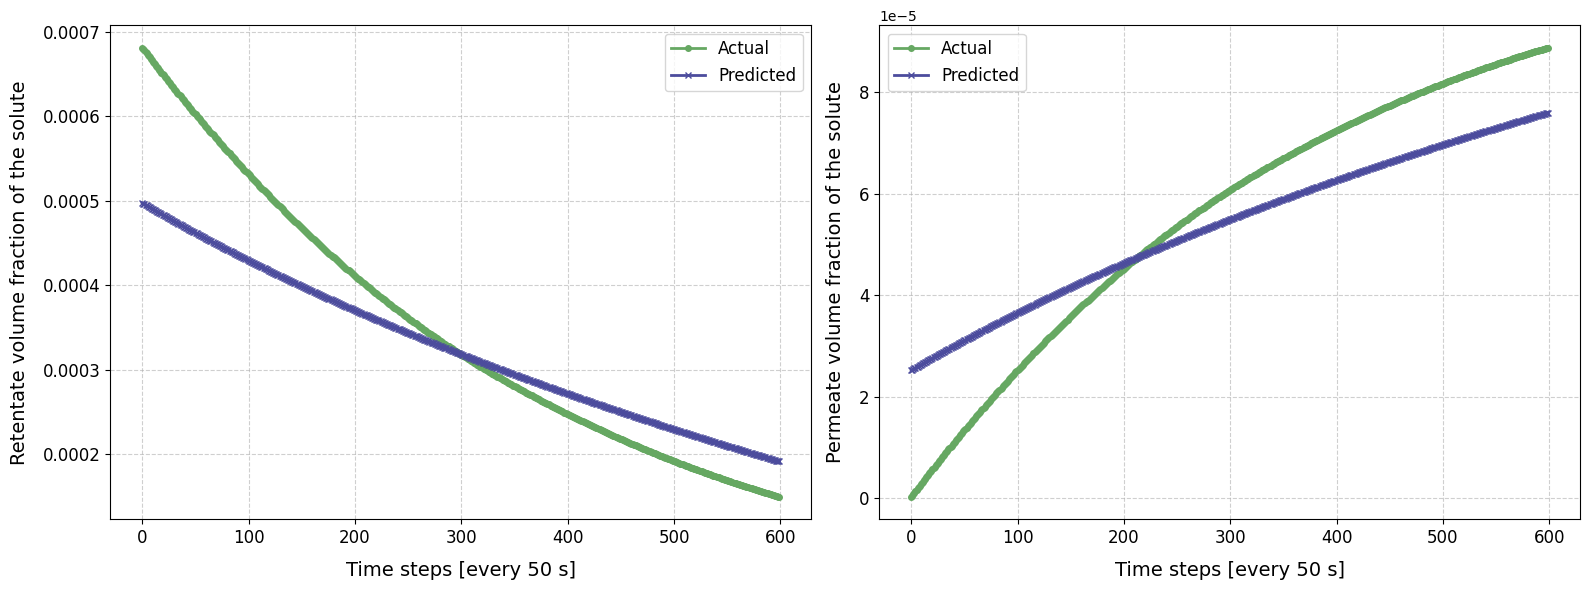

In [ ]:
import random
import matplotlib.pyplot as plt

# Select a random simulation ID from the test set
# random_sim_id = random.choice(groups.iloc[test_idx].unique())

# Filter the test data for the selected simulation
X_simulation = X_test[groups.iloc[test_idx] ==random_sim_id]
Y_simulation = Y_test[groups.iloc[test_idx] == random_sim_id]

# Scale the inputs for prediction
X_simulation_scaled = feature_scaler.transform(X_simulation)

# Predict for the chosen simulation
Y_simulation_pred = pls_model_logx.predict(X_simulation_scaled)


# Convert to DataFrame for easier handling
Y_simulation_actual_df = pd.DataFrame(Y_simulation.values, columns=Y.columns)
Y_simulation_pred_df = pd.DataFrame(Y_simulation_pred, columns=Y.columns)

# Choose a single target
target_name = '5nm_permeate'  # Replace with your desired target
Y_actual_1 = Y_simulation_actual_df[target_name]
Y_pred_1 = Y_simulation_pred_df[target_name]

target_name_2 = '5nm_retentate'  # Replace with your desired target
Y_actual = Y_simulation_actual_df[target_name_2]
Y_pred = Y_simulation_pred_df[target_name_2]

# Create a figure with one row and two columns
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot for retentate (first column)
axes[0].plot(Y_actual.values, label='Actual', marker='o', color='#66a862', linewidth=2, markersize=4)
axes[0].plot(Y_pred.values, label='Predicted', marker='x', color='#4C4C9D', linewidth=2, markersize=4)
# axes[0].set_title(f"Retentate: Predicted vs Actual\nSimulation ID: {random_sim_id}", fontsize=14)
axes[0].set_xlabel('Time steps [every 50 s]', fontsize=14, labelpad=10)
axes[0].set_ylabel('Retentate volume fraction of the solute', fontsize=14, labelpad=10)
axes[0].legend(fontsize=12, loc='best')
axes[0].grid(True, linestyle='--', alpha=0.6)
axes[0].tick_params(axis='both', which='major', labelsize=12)

# Plot for permeate (second column)
axes[1].plot(Y_actual_1.values, label='Actual', marker='o', color='#66a862', linewidth=2, markersize=4)
axes[1].plot(Y_pred_1.values, label='Predicted', marker='x', color='#4C4C9D', linewidth=2, markersize=4)
# axes[1].set_title(f"Permeate: Predicted vs Actual\nSimulation ID: {random_sim_id}", fontsize=14)
axes[1].set_xlabel('Time steps [every 50 s]', fontsize=14, labelpad=10)
axes[1].set_ylabel('Permeate volume fraction of the solute', fontsize=14, labelpad=10)
axes[1].legend(fontsize=12, loc='best')
axes[1].grid(True, linestyle='--', alpha=0.6)
axes[1].tick_params(axis='both', which='major', labelsize=12)

# Tight layout for better spacing
plt.tight_layout()

# Save the figure as a high-resolution image

plt.savefig('retentate_permeate_comparison_log.png' ,dpi=300)


# Show the plot
plt.show()



In [ ]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import GroupKFold, GroupShuffleSplit
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

# # Add normalized time to the features
# def normalize_time_per_simulation(df, simulation_column, time_column):
#     df['Normalized_Time'] = df.groupby(simulation_column)[time_column].transform(lambda x: x / x.max())
#     return df

# # Apply the function to normalize time
# sampled_data = normalize_time_per_simulation(sampled_data, simulation_column='Simulation_ID', time_column='Time (s)')

# Define features and targets
# X = sampled_data.drop(columns=['Simulation_ID', 'Time (s)', 
#                                '5nm_retentate', '5nm_permeate', '5nm_cumulative_yield', '5nm_size_solute',
#                                '40nm_retentate', '40nm_permeate', '40nm_cumulative_yield', '40nm_size_solute',
#                                '70nm_retentate', '70nm_permeate', '70nm_cumulative_yield', '70nm_size_solute',
#                                '120nm_retentate', '120nm_permeate', '120nm_cumulative_yield', '120nm_size_solute',
#                                '190nm_retentate', '190nm_permeate', '190nm_cumulative_yield', '190nm_size_solute',
#                                '300nm_retentate', '300nm_permeate', '300nm_cumulative_yield', '300nm_size_solute',
#                                '700nm_retentate', '700nm_permeate', '700nm_cumulative_yield', '700nm_size_solute',
#                                '2500nm_retentate', '2500nm_permeate', '2500nm_cumulative_yield', '2500nm_size_solute',
#                                'Diavolumes'])

# Apply log transformation to all features
X_exp = np.exp(X)

# # Define target variables
# Y = sampled_data[['5nm_retentate', '5nm_permeate',
#                   '40nm_retentate', '40nm_permeate', 
#                   '70nm_retentate', '70nm_permeate',   
#                   '120nm_retentate', '120nm_permeate',  
#                   '190nm_retentate', '190nm_permeate', 
#                   '300nm_retentate', '300nm_permeate', 
#                   '700nm_retentate', '700nm_permeate', 
#                   '2500nm_retentate', '2500nm_permeate',
#                   'Diavolumes']]

# Apply log transformation to targets

groups = sampled_data['Simulation_ID']

# Define the number of components for PLS
n_components = 7

# Split data into train-validation and test sets
# group_split = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_val_idx, test_idx = next(group_split.split(X_exp, Y, groups))

X_train_val, X_test = X_exp.iloc[train_val_idx], X_exp.iloc[test_idx]
Y_train_val, Y_test = Y.iloc[train_val_idx], Y.iloc[test_idx]
groups_train_val = groups.iloc[train_val_idx]

# Initialize scalers
feature_scaler = StandardScaler()

# Set up 5-fold cross-validation
n_folds = 5
group_kfold = GroupKFold(n_splits=n_folds)

# Initialize placeholders for aggregate metrics
validation_q2_list, validation_r2_list = [], []
validation_mae_list, validation_mape_list = [], []
validation_mse_list, validation_rmse_list = [], []

# Cross-validation loop
for fold, (train_idx, val_idx) in enumerate(group_kfold.split(X_train_val, Y_train_val, groups_train_val), start=1):
    # Split data
    X_train_fold, X_val_fold = X_train_val.iloc[train_idx], X_train_val.iloc[val_idx]
    Y_train_fold, Y_val_fold = Y_train_val.iloc[train_idx], Y_train_val.iloc[val_idx]

    # Scale data
    X_train_fold_scaled = feature_scaler.fit_transform(X_train_fold)

    X_val_fold_scaled = feature_scaler.transform(X_val_fold)
   

    # Train the model
    pls_model_exp= PLSRegression(n_components=n_components)
    pls_model_exp.fit(X_train_fold_scaled, Y_train_fold)

    # Predict on validation set
    Y_val_pred = pls_model_exp.predict(X_val_fold_scaled)
    

    # Compute metrics for validation set
    val_mse = mean_squared_error(Y_val_fold ,Y_val_pred, multioutput='raw_values')
    val_rmse = np.sqrt(val_mse)
    val_r2 = r2_score(Y_val_fold, Y_val_pred, multioutput='uniform_average')
    val_mae = mean_absolute_error(Y_val_fold, Y_val_pred, multioutput='raw_values')

    train_mean = Y_train_fold.mean(axis=0)  # Mean of the training set
    val_q2 = 1 - (np.sum((Y_val_fold - Y_val_pred) ** 2, axis=0) /
                  np.sum((Y_val_fold - train_mean) ** 2, axis=0))
    val_q2 = np.mean(val_q2)  # Average Q² across all targets

    # Aggregate metrics across folds
    validation_q2_list.append(val_q2)
    validation_r2_list.append(val_r2)
    validation_mae_list.append(np.mean(val_mae))
    validation_mse_list.append(np.mean(val_mse))
    validation_rmse_list.append(np.mean(val_rmse))

# Compute averages across all folds for validation
avg_val_q2 = np.mean(validation_q2_list)
avg_val_r2 = np.mean(validation_r2_list)
avg_val_mae = np.mean(validation_mae_list)
avg_val_mse = np.mean(validation_mse_list)
avg_val_rmse = np.mean(validation_rmse_list)

# Print validation results
print(f"\nValidation Results (Averaged Across Folds):")
print(f"  Q²: {avg_val_q2:.7f}")
print(f"  R²: {avg_val_r2:.7f}")
print(f"  MAE: {avg_val_mae:.7f}")
print(f"  MSE: {avg_val_mse:.7f}")
print(f"  RMSE: {avg_val_rmse:.7f}")

# Compute metrics per target for validation
print("\nValidation Metrics Per Target:")
for i, target in enumerate(Y.columns):
    target_val_r2 = r2_score(Y_val_fold.iloc[:, i], Y_val_pred[:, i])
    target_val_mse = mean_squared_error(Y_val_fold.iloc[:, i], Y_val_pred[:, i])
    target_val_rmse = np.sqrt(target_val_mse)
    target_val_mae = mean_absolute_error(Y_val_fold.iloc[:, i], Y_val_pred[:, i])
    target_val_q2 = 1 - (
        np.sum((Y_val_fold.iloc[:, i] - Y_val_pred[:, i]) ** 2) /
        np.sum((Y_val_fold.iloc[:, i] - np.mean(Y_val_fold.iloc[:, i])) ** 2)
    )
    print(f"Target: {target}")
    print(f"  R²: {target_val_r2:.7f}")
    print(f"  Q²: {target_val_q2:.7f}")
    print(f"  MAE: {target_val_mae:.7f}")
    print(f"  MSE: {target_val_mse:.7f}")
    print(f"  RMSE: {target_val_rmse:.7f}")

X_test_scaled = feature_scaler.transform(X_test)

# Evaluate on test set
Y_test_pred = pls_model_exp.predict(X_test_scaled)

# Compute metrics for test set
test_mse = mean_squared_error(Y_test, Y_test_pred, multioutput='raw_values')
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(Y_test, Y_test_pred, multioutput='uniform_average')
test_mae = mean_absolute_error(Y_test, Y_test_pred, multioutput='raw_values')

test_q2 = np.mean(1 - (np.sum((Y_test - Y_test_pred) ** 2, axis=0) /
                       np.sum((Y_test - Y_test.mean(axis=0)) ** 2, axis=0)))  # Q²

# Print test results
print(f"\nTest Results:")
print(f"  Q²: {test_q2:.7f}")
print(f"  R²: {test_r2:.7f}")
print(f"  MAE: {np.mean(test_mae):.7f}")
print(f"  MSE: {np.mean(test_mse):.7f}")
print(f"  RMSE: {np.mean(test_rmse):.7f}")

# Compute metrics per target for test
print("\nTest Metrics Per Target:")
for i, target in enumerate(Y.columns):
    target_test_r2 = r2_score(Y_test.iloc[:, i], Y_test_pred[:, i])
    target_test_mse = mean_squared_error(Y_test.iloc[:, i], Y_test_pred[:, i])
    target_test_rmse = np.sqrt(target_test_mse)
    target_test_mae = mean_absolute_error(Y_test.iloc[:, i], Y_test_pred[:, i])
    target_test_q2 = 1 - (
        np.sum((Y_test.iloc[:, i] - Y_test_pred[:, i]) ** 2) /
        np.sum((Y_test.iloc[:, i] - np.mean(Y_test.iloc[:, i])) ** 2)
    )
    print(f"Target: {target}")
    print(f"  R²: {target_test_r2:.7f}")
    print(f"  Q²: {target_test_q2:.7f}")
    print(f"  MAE: {target_test_mae:.7f}")
    print(f"  MSE: {target_test_mse:.7f}")
    print(f"  RMSE: {target_test_rmse:.7f}")


Validation Results (Averaged Across Folds):
  Q²: 0.4999273
  R²: 0.5290465
  MAE: 0.0227924
  MSE: 0.0176962
  RMSE: 0.0324051

Validation Metrics Per Target:
Target: 5nm_retentate
  R²: 0.4590744
  Q²: 0.4590744
  MAE: 0.0001070
  MSE: 0.0000000
  RMSE: 0.0001364
Target: 5nm_permeate
  R²: 0.4895800
  Q²: 0.4895800
  MAE: 0.0000188
  MSE: 0.0000000
  RMSE: 0.0000235
Target: 40nm_retentate
  R²: 0.5345780
  Q²: 0.5345780
  MAE: 0.0001608
  MSE: 0.0000000
  RMSE: 0.0001978
Target: 40nm_permeate
  R²: 0.4920414
  Q²: 0.4920414
  MAE: 0.0000241
  MSE: 0.0000000
  RMSE: 0.0000305
Target: 70nm_retentate
  R²: 0.5653751
  Q²: 0.5653751
  MAE: 0.0004431
  MSE: 0.0000003
  RMSE: 0.0005469
Target: 70nm_permeate
  R²: 0.4132595
  Q²: 0.4132595
  MAE: 0.0000560
  MSE: 0.0000000
  RMSE: 0.0000714
Target: 120nm_retentate
  R²: 0.6060949
  Q²: 0.6060949
  MAE: 0.0004113
  MSE: 0.0000003
  RMSE: 0.0005032
Target: 120nm_permeate
  R²: 0.3616123
  Q²: 0.3616123
  MAE: 0.0000396
  MSE: 0.0000000
  RMS

/var/folders/x1/1094qf1d4c1g3_6s3f1qxk_h0000gn/T/ipykernel_1355/698439282.py:130: RuntimeWarning: invalid value encountered in scalar divide
  np.sum((Y_val_fold.iloc[:, i] - Y_val_pred[:, i]) ** 2) /


Target: Diavolumes
  R²: 0.4175579
  Q²: 0.4175579
  MAE: 0.3974684
  MSE: 0.3195760
  RMSE: 0.5653105

Test Results:
  Q²: 0.5004891
  R²: 0.5298721
  MAE: 0.0228163
  MSE: 0.0178749
  RMSE: 0.0325714

Test Metrics Per Target:
Target: 5nm_retentate
  R²: 0.4490329
  Q²: 0.4490329
  MAE: 0.0001060
  MSE: 0.0000000
  RMSE: 0.0001347
Target: 5nm_permeate
  R²: 0.4864340
  Q²: 0.4864340
  MAE: 0.0000185
  MSE: 0.0000000
  RMSE: 0.0000232
Target: 40nm_retentate
  R²: 0.5059637
  Q²: 0.5059637
  MAE: 0.0001639
  MSE: 0.0000000
  RMSE: 0.0002021
Target: 40nm_permeate
  R²: 0.4970504
  Q²: 0.4970504
  MAE: 0.0000236
  MSE: 0.0000000
  RMSE: 0.0000302
Target: 70nm_retentate
  R²: 0.5462972
  Q²: 0.5462972
  MAE: 0.0004470
  MSE: 0.0000003
  RMSE: 0.0005529
Target: 70nm_permeate
  R²: 0.4127894
  Q²: 0.4127894
  MAE: 0.0000550
  MSE: 0.0000000
  RMSE: 0.0000709
Target: 120nm_retentate
  R²: 0.6020986
  Q²: 0.6020986
  MAE: 0.0004088
  MSE: 0.0000002
  RMSE: 0.0004990
Target: 120nm_permeate
  R²

/var/folders/x1/1094qf1d4c1g3_6s3f1qxk_h0000gn/T/ipykernel_1355/698439282.py:170: RuntimeWarning: invalid value encountered in scalar divide
  np.sum((Y_test.iloc[:, i] - Y_test_pred[:, i]) ** 2) /


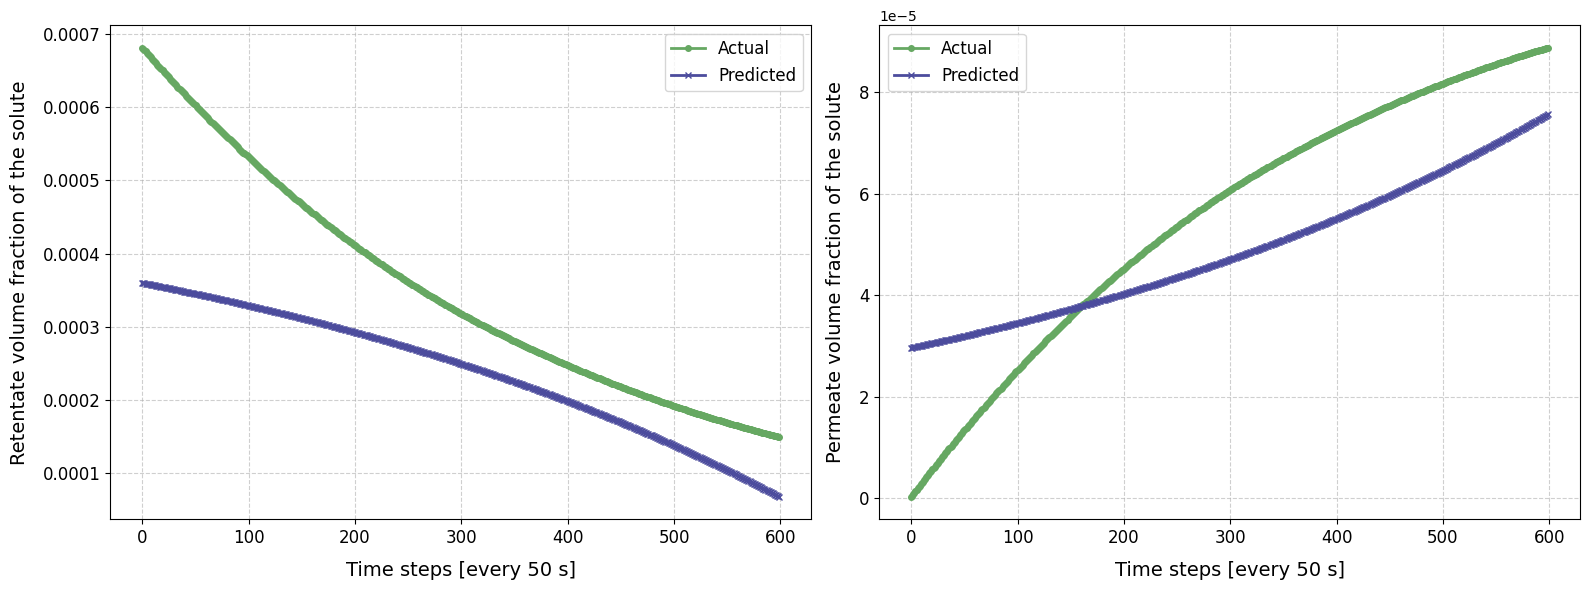

In [ ]:
import random
import matplotlib.pyplot as plt

# Select a random simulation ID from the test set
# random_sim_id = random.choice(groups.iloc[test_idx].unique())

# Filter the test data for the selected simulation
X_simulation = X_test[groups.iloc[test_idx] == random_sim_id]
Y_simulation = Y_test[groups.iloc[test_idx] == random_sim_id]

# Scale the inputs for prediction
X_simulation_scaled = feature_scaler.transform(X_simulation)

# Predict for the chosen simulation
Y_simulation_pred = pls_model_exp.predict(X_simulation_scaled)


# Convert to DataFrame for easier handling
Y_simulation_actual_df_1 = pd.DataFrame(Y_simulation.values, columns=Y.columns)
Y_simulation_pred_df_1 = pd.DataFrame(Y_simulation_pred, columns=Y.columns)

# Choose a single target
target_name = '5nm_permeate'  # Replace with your desired target
Y_actual_1 = Y_simulation_actual_df_1[target_name]
Y_pred_1 = Y_simulation_pred_df_1[target_name]

target_name_2 = '5nm_retentate'  # Replace with your desired target
Y_actual = Y_simulation_actual_df_1[target_name_2]
Y_pred = Y_simulation_pred_df_1[target_name_2]

# Create a figure with one row and two columns
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot for retentate (first column)
axes[0].plot(Y_actual.values, label='Actual', marker='o', color='#66a862', linewidth=2, markersize=4)
axes[0].plot(Y_pred.values, label='Predicted', marker='x', color='#4C4C9D', linewidth=2, markersize=4)
# axes[0].set_title(f"Retentate: Predicted vs Actual\nSimulation ID: {random_sim_id}", fontsize=14)
axes[0].set_xlabel('Time steps [every 50 s]', fontsize=14, labelpad=10)
axes[0].set_ylabel('Retentate volume fraction of the solute', fontsize=14, labelpad=10)
axes[0].legend(fontsize=12, loc='best')
axes[0].grid(True, linestyle='--', alpha=0.6)
axes[0].tick_params(axis='both', which='major', labelsize=12)

# Plot for permeate (second column)
axes[1].plot(Y_actual_1.values, label='Actual', marker='o', color='#66a862', linewidth=2, markersize=4)
axes[1].plot(Y_pred_1.values, label='Predicted', marker='x', color='#4C4C9D', linewidth=2, markersize=4)
# axes[1].set_title(f"Permeate: Predicted vs Actual\nSimulation ID: {random_sim_id}", fontsize=14)
axes[1].set_xlabel('Time steps [every 50 s]', fontsize=14, labelpad=10)
axes[1].set_ylabel('Permeate volume fraction of the solute', fontsize=14, labelpad=10)
axes[1].legend(fontsize=12, loc='best')
axes[1].grid(True, linestyle='--', alpha=0.6)
axes[1].tick_params(axis='both', which='major', labelsize=12)

# Tight layout for better spacing
plt.tight_layout()

# Save the figure as a high-resolution image

plt.savefig('retentate_permeate_comparison_exp.png' ,dpi=300)


# Show the plot
plt.show()


In [3]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import GroupKFold, GroupShuffleSplit
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

# # Add normalized time to the features
# def normalize_time_per_simulation(df, simulation_column, time_column):
#     df['Normalized_Time'] = df.groupby(simulation_column)[time_column].transform(lambda x: x / x.max())
#     return df

# # Apply the function to normalize time
# sampled_data = normalize_time_per_simulation(sampled_data, simulation_column='Simulation_ID', time_column='Time (s)')

# Define features and targets
# X = sampled_data.drop(columns=['Simulation_ID', 'Time (s)', 
#                                '5nm_retentate', '5nm_permeate', '5nm_cumulative_yield', '5nm_size_solute',
#                                '40nm_retentate', '40nm_permeate', '40nm_cumulative_yield', '40nm_size_solute',
#                                '70nm_retentate', '70nm_permeate', '70nm_cumulative_yield', '70nm_size_solute',
#                                '120nm_retentate', '120nm_permeate', '120nm_cumulative_yield', '120nm_size_solute',
#                                '190nm_retentate', '190nm_permeate', '190nm_cumulative_yield', '190nm_size_solute',
#                                '300nm_retentate', '300nm_permeate', '300nm_cumulative_yield', '300nm_size_solute',
#                                '700nm_retentate', '700nm_permeate', '700nm_cumulative_yield', '700nm_size_solute',
#                                '2500nm_retentate', '2500nm_permeate', '2500nm_cumulative_yield', '2500nm_size_solute',
#                                'Diavolumes'])

# Apply log transformation to all features
X_sqrt = np.sqrt(X)

# # Define target variables
# Y = sampled_data[['5nm_retentate', '5nm_permeate',
#                   '40nm_retentate', '40nm_permeate', 
#                   '70nm_retentate', '70nm_permeate',   
#                   '120nm_retentate', '120nm_permeate',  
#                   '190nm_retentate', '190nm_permeate', 
#                   '300nm_retentate', '300nm_permeate', 
#                   '700nm_retentate', '700nm_permeate', 
#                   '2500nm_retentate', '2500nm_permeate',
#                   'Diavolumes']]

# Apply log transformation to targets

# groups = sampled_data['Simulation_ID']

# Define the number of components for PLS
n_components = 5

# Split data into train-validation and test sets
# group_split = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_val_idx, test_idx = next(group_split.split(X_sqrt, Y, groups))

X_train_val, X_test = X_sqrt.iloc[train_val_idx], X_sqrt.iloc[test_idx]
Y_train_val, Y_test = Y.iloc[train_val_idx], Y.iloc[test_idx]
groups_train_val = groups.iloc[train_val_idx]

# Initialize scalers
feature_scaler = StandardScaler()

# Set up 5-fold cross-validation
n_folds = 5
group_kfold = GroupKFold(n_splits=n_folds)

# Initialize placeholders for aggregate metrics
validation_q2_list, validation_r2_list = [], []
validation_mae_list, validation_mape_list = [], []
validation_mse_list, validation_rmse_list = [], []

# Cross-validation loop
for fold, (train_idx, val_idx) in enumerate(group_kfold.split(X_train_val, Y_train_val, groups_train_val), start=1):
    # Split data
    X_train_fold, X_val_fold = X_train_val.iloc[train_idx], X_train_val.iloc[val_idx]
    Y_train_fold, Y_val_fold = Y_train_val.iloc[train_idx], Y_train_val.iloc[val_idx]

    # Scale data
    X_train_fold_scaled = feature_scaler.fit_transform(X_train_fold)

    X_val_fold_scaled = feature_scaler.transform(X_val_fold)
   

    # Train the model
    pls_model_sqrt= PLSRegression(n_components=n_components)
    pls_model_sqrt.fit(X_train_fold_scaled, Y_train_fold)
    
    # Predict on validation set
    Y_val_pred = pls_model_sqrt.predict(X_val_fold_scaled)
    

    # Compute metrics for validation set
    val_mse = mean_squared_error(Y_val_fold ,Y_val_pred, multioutput='raw_values')
    val_rmse = np.sqrt(val_mse)
    val_r2 = r2_score(Y_val_fold, Y_val_pred, multioutput='uniform_average')
    val_mae = mean_absolute_error(Y_val_fold, Y_val_pred, multioutput='raw_values')



    # Aggregate metrics across folds
   
    validation_r2_list.append(val_r2)
    validation_mae_list.append(np.mean(val_mae))
    validation_mse_list.append(np.mean(val_mse))
    validation_rmse_list.append(np.mean(val_rmse))

# Compute averages across all folds for validation
# Compute averages across all folds for validation

avg_val_r2 = np.mean(validation_r2_list)
avg_val_mae = np.mean(validation_mae_list)
avg_val_mse = np.mean(validation_mse_list)
avg_val_rmse = np.mean(validation_rmse_list)

# Print validation results
print(f"\nValidation Results (Averaged Across Folds):")

print(f"  R²: {avg_val_r2:.7f}")
print(f"  MAE: {avg_val_mae:.7f}")
print(f"  MSE: {avg_val_mse:.7f}")
print(f"  RMSE: {avg_val_rmse:.7f}")

# Compute metrics per target for validation
print("\nValidation Metrics Per Target:")
for i, target in enumerate(Y.columns):
    target_val_r2 = r2_score(Y_val_fold.iloc[:, i], Y_val_pred[:, i])
    target_val_mse = mean_squared_error(Y_val_fold.iloc[:, i], Y_val_pred[:, i])
    target_val_rmse = np.sqrt(target_val_mse)
    target_val_mae = mean_absolute_error(Y_val_fold.iloc[:, i], Y_val_pred[:, i])
    
    print(f"Target: {target}")
    print(f"  R²: {target_val_r2:.7f}")
    print(f"  MAE: {target_val_mae:.7f}")
    print(f"  MSE: {target_val_mse:.7f}")
    print(f"  RMSE: {target_val_rmse:.7f}")

X_test_scaled = feature_scaler.transform(X_test)

# Evaluate on test set
Y_test_pred = pls_model_sqrt.predict(X_test_scaled)

# Compute metrics for test set
test_mse = mean_squared_error(Y_test, Y_test_pred, multioutput='raw_values')
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(Y_test, Y_test_pred, multioutput='uniform_average')
test_mae = mean_absolute_error(Y_test, Y_test_pred, multioutput='raw_values')

# Print test results
print(f"\nTest Results:")

print(f"  R²: {test_r2:.7f}")
print(f"  MAE: {np.mean(test_mae):.7f}")
print(f"  MSE: {np.mean(test_mse):.7f}")
print(f"  RMSE: {np.mean(test_rmse):.7f}")

# Compute metrics per target for test
print("\nTest Metrics Per Target:")
for i, target in enumerate(Y.columns):
    target_test_r2 = r2_score(Y_test.iloc[:, i], Y_test_pred[:, i])
    target_test_mse = mean_squared_error(Y_test.iloc[:, i], Y_test_pred[:, i])
    target_test_rmse = np.sqrt(target_test_mse)
    target_test_mae = mean_absolute_error(Y_test.iloc[:, i], Y_test_pred[:, i])
  
    print(f"Target: {target}")
    print(f"  R²: {target_test_r2:.7f}")

    print(f"  MAE: {target_test_mae:.7f}")
    print(f"  MSE: {target_test_mse:.7f}")
    print(f"  RMSE: {target_test_rmse:.7f}")



Validation Results (Averaged Across Folds):
  Q²: 0.7087975
  R²: 0.7257435
  MAE: 0.0195070
  MSE: 0.0112495
  RMSE: 0.0258071

Validation Metrics Per Target:
Target: 5nm_retentate
  R²: 0.6869503
  Q²: 0.6869503
  MAE: 0.0000834
  MSE: 0.0000000
  RMSE: 0.0001038
Target: 5nm_permeate
  R²: 0.7188924
  Q²: 0.7188924
  MAE: 0.0000141
  MSE: 0.0000000
  RMSE: 0.0000174
Target: 40nm_retentate
  R²: 0.7447781
  Q²: 0.7447781
  MAE: 0.0001191
  MSE: 0.0000000
  RMSE: 0.0001465
Target: 40nm_permeate
  R²: 0.6821389
  Q²: 0.6821389
  MAE: 0.0000196
  MSE: 0.0000000
  RMSE: 0.0000241
Target: 70nm_retentate
  R²: 0.7713407
  Q²: 0.7713407
  MAE: 0.0003105
  MSE: 0.0000002
  RMSE: 0.0003967
Target: 70nm_permeate
  R²: 0.5472759
  Q²: 0.5472759
  MAE: 0.0000488
  MSE: 0.0000000
  RMSE: 0.0000627
Target: 120nm_retentate
  R²: 0.8510889
  Q²: 0.8510889
  MAE: 0.0002394
  MSE: 0.0000001
  RMSE: 0.0003094
Target: 120nm_permeate
  R²: 0.4905372
  Q²: 0.4905372
  MAE: 0.0000346
  MSE: 0.0000000
  RMS

/var/folders/x1/1094qf1d4c1g3_6s3f1qxk_h0000gn/T/ipykernel_10685/2652782614.py:131: RuntimeWarning: invalid value encountered in scalar divide
  np.sum((Y_val_fold.iloc[:, i] - Y_val_pred[:, i]) ** 2) /



Test Results:
  Q²: 0.7098928
  R²: 0.7269580
  MAE: 0.0195587
  MSE: 0.0112923
  RMSE: 0.0258576

Test Metrics Per Target:
Target: 5nm_retentate
  R²: 0.6974390
  Q²: 0.6974390
  MAE: 0.0000808
  MSE: 0.0000000
  RMSE: 0.0000998
Target: 5nm_permeate
  R²: 0.7261638
  Q²: 0.7261638
  MAE: 0.0000137
  MSE: 0.0000000
  RMSE: 0.0000170
Target: 40nm_retentate
  R²: 0.7424195
  Q²: 0.7424195
  MAE: 0.0001186
  MSE: 0.0000000
  RMSE: 0.0001459
Target: 40nm_permeate
  R²: 0.6721836
  Q²: 0.6721836
  MAE: 0.0000196
  MSE: 0.0000000
  RMSE: 0.0000244
Target: 70nm_retentate
  R²: 0.7702443
  Q²: 0.7702443
  MAE: 0.0003099
  MSE: 0.0000002
  RMSE: 0.0003935
Target: 70nm_permeate
  R²: 0.5396346
  Q²: 0.5396346
  MAE: 0.0000489
  MSE: 0.0000000
  RMSE: 0.0000628
Target: 120nm_retentate
  R²: 0.8527123
  Q²: 0.8527123
  MAE: 0.0002377
  MSE: 0.0000001
  RMSE: 0.0003036
Target: 120nm_permeate
  R²: 0.4939348
  Q²: 0.4939348
  MAE: 0.0000341
  MSE: 0.0000000
  RMSE: 0.0000452
Target: 190nm_retentate

/var/folders/x1/1094qf1d4c1g3_6s3f1qxk_h0000gn/T/ipykernel_10685/2652782614.py:171: RuntimeWarning: invalid value encountered in scalar divide
  np.sum((Y_test.iloc[:, i] - Y_test_pred[:, i]) ** 2) /


In [3]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import GroupKFold, GroupShuffleSplit
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

# # Add normalized time to the features
# def normalize_time_per_simulation(df, simulation_column, time_column):
#     df['Normalized_Time'] = df.groupby(simulation_column)[time_column].transform(lambda x: x / x.max())
#     return df

# # Apply the function to normalize time
# sampled_data = normalize_time_per_simulation(sampled_data, simulation_column='Simulation_ID', time_column='Time (s)')

# Define features and targets
# X = sampled_data.drop(columns=['Simulation_ID', 'Time (s)', 
#                                '5nm_retentate', '5nm_permeate', '5nm_cumulative_yield', '5nm_size_solute',
#                                '40nm_retentate', '40nm_permeate', '40nm_cumulative_yield', '40nm_size_solute',
#                                '70nm_retentate', '70nm_permeate', '70nm_cumulative_yield', '70nm_size_solute',
#                                '120nm_retentate', '120nm_permeate', '120nm_cumulative_yield', '120nm_size_solute',
#                                '190nm_retentate', '190nm_permeate', '190nm_cumulative_yield', '190nm_size_solute',
#                                '300nm_retentate', '300nm_permeate', '300nm_cumulative_yield', '300nm_size_solute',
#                                '700nm_retentate', '700nm_permeate', '700nm_cumulative_yield', '700nm_size_solute',
#                                '2500nm_retentate', '2500nm_permeate', '2500nm_cumulative_yield', '2500nm_size_solute',
#                                'Diavolumes'])

# Apply log transformation to all features
X_sqrt = np.sqrt(X)

# # Define target variables
# Y = sampled_data[['5nm_retentate', '5nm_permeate',
#                   '40nm_retentate', '40nm_permeate', 
#                   '70nm_retentate', '70nm_permeate',   
#                   '120nm_retentate', '120nm_permeate',  
#                   '190nm_retentate', '190nm_permeate', 
#                   '300nm_retentate', '300nm_permeate', 
#                   '700nm_retentate', '700nm_permeate', 
#                   '2500nm_retentate', '2500nm_permeate',
#                   'Diavolumes']]

# Apply log transformation to targets

# groups = sampled_data['Simulation_ID']

# Define the number of components for PLS
n_components = 5

# Split data into train-validation and test sets
# group_split = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_val_idx, test_idx = next(group_split.split(X_sqrt, Y, groups))

X_train_val, X_test = X_sqrt.iloc[train_val_idx], X_sqrt.iloc[test_idx]
Y_train_val, Y_test = Y.iloc[train_val_idx], Y.iloc[test_idx]
groups_train_val = groups.iloc[train_val_idx]

# Initialize scalers
feature_scaler = StandardScaler()

# Set up 5-fold cross-validation
n_folds = 5
group_kfold = GroupKFold(n_splits=n_folds)

# Initialize placeholders for aggregate metrics
validation_q2_list, validation_r2_list = [], []
validation_mae_list, validation_mape_list = [], []
validation_mse_list, validation_rmse_list = [], []

# Cross-validation loop
for fold, (train_idx, val_idx) in enumerate(group_kfold.split(X_train_val, Y_train_val, groups_train_val), start=1):
    # Split data
    X_train_fold, X_val_fold = X_train_val.iloc[train_idx], X_train_val.iloc[val_idx]
    Y_train_fold, Y_val_fold = Y_train_val.iloc[train_idx], Y_train_val.iloc[val_idx]

    # Scale data
    X_train_fold_scaled = feature_scaler.fit_transform(X_train_fold)

    X_val_fold_scaled = feature_scaler.transform(X_val_fold)
   

    # Train the model
    pls_model_sqrt= PLSRegression(n_components=n_components)
    pls_model_sqrt.fit(X_train_fold_scaled, Y_train_fold)
    
    # Predict on validation set
    Y_val_pred = pls_model_sqrt.predict(X_val_fold_scaled)
    

    

X_test_scaled = feature_scaler.transform(X_test)

# Evaluate on test set
Y_test_pred = pls_model_sqrt.predict(X_test_scaled)




X_train_fold_scaled shape: (2454114, 15)
X_test_scaled shape: (758608, 15)
shap_values shape: (758608, 15, 17)
SHAP summary for output 5nm_retentate:


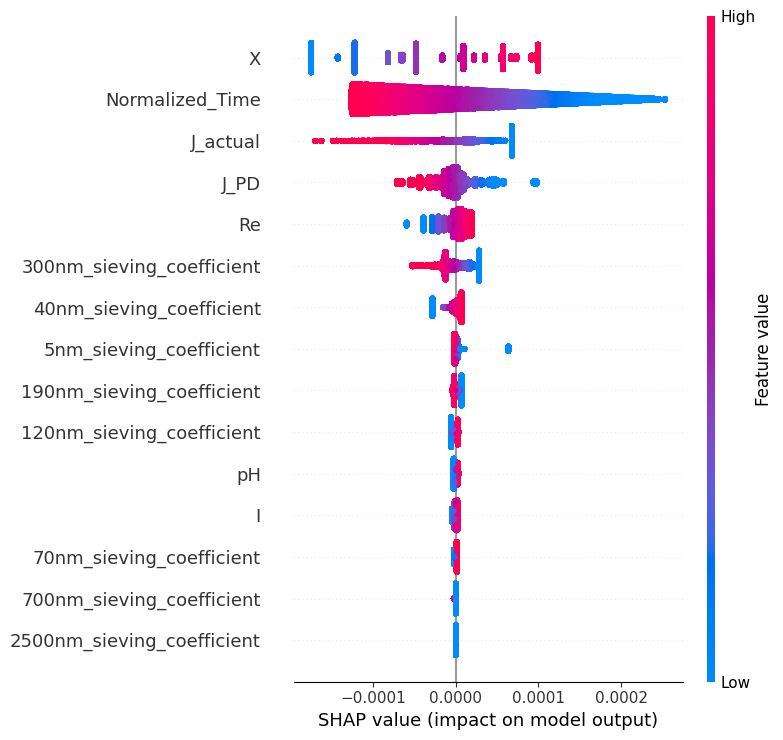

SHAP summary for output 5nm_permeate:


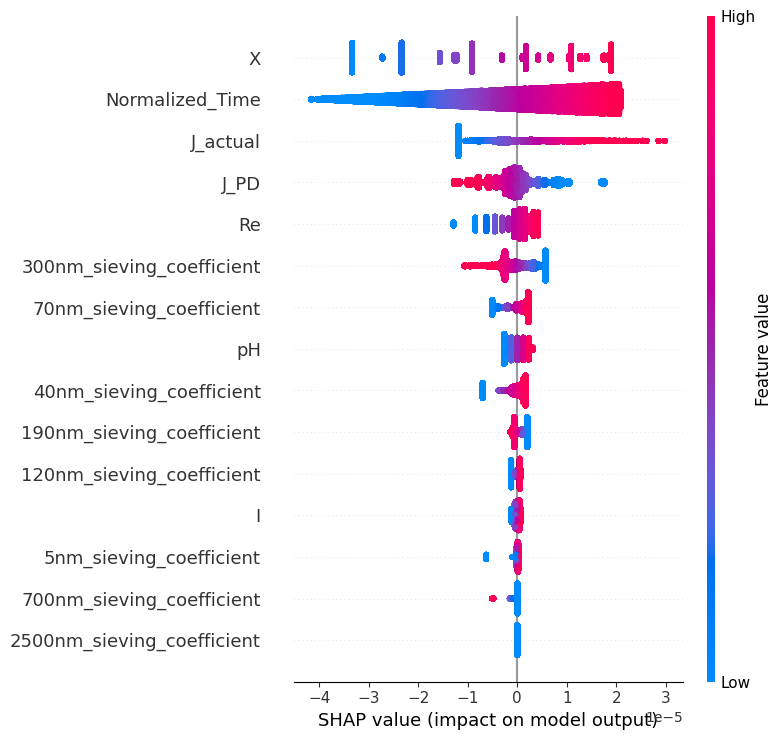

SHAP summary for output 40nm_retentate:


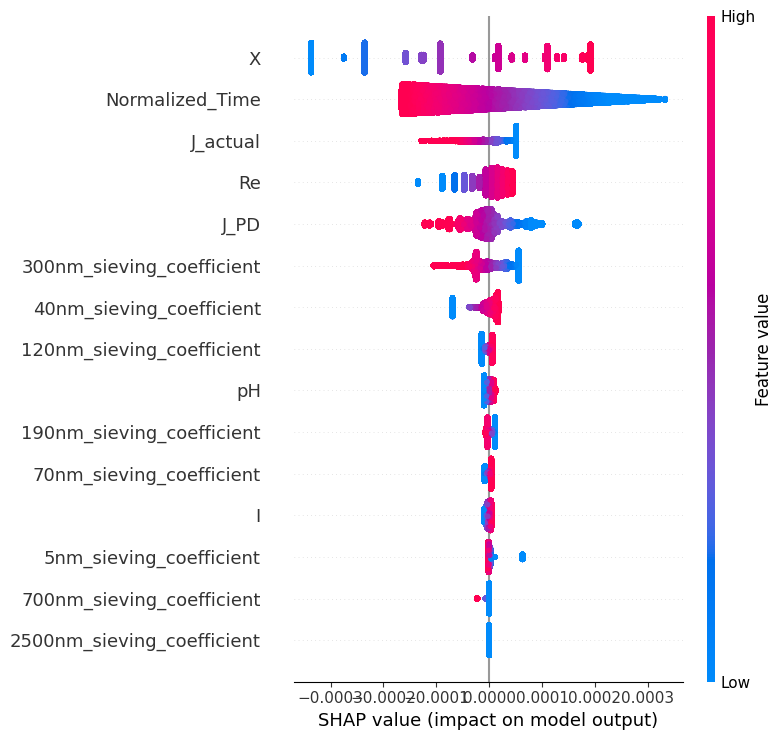

SHAP summary for output 40nm_permeate:


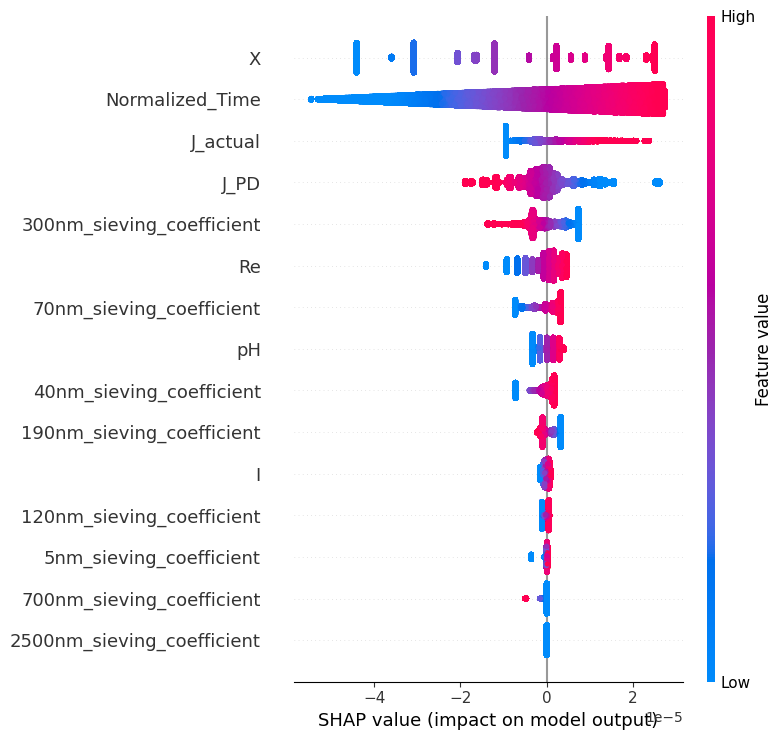

SHAP summary for output 70nm_retentate:


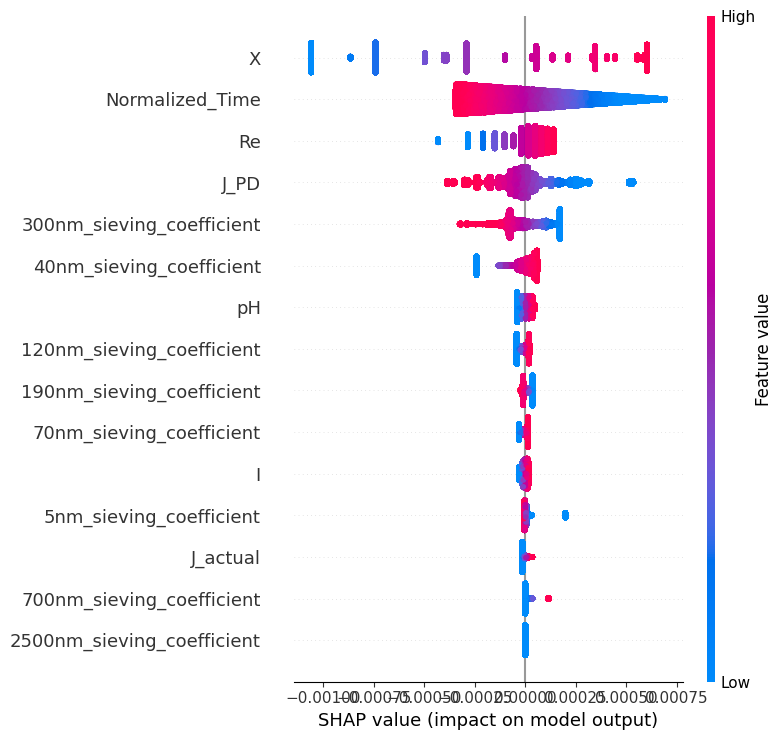

SHAP summary for output 70nm_permeate:


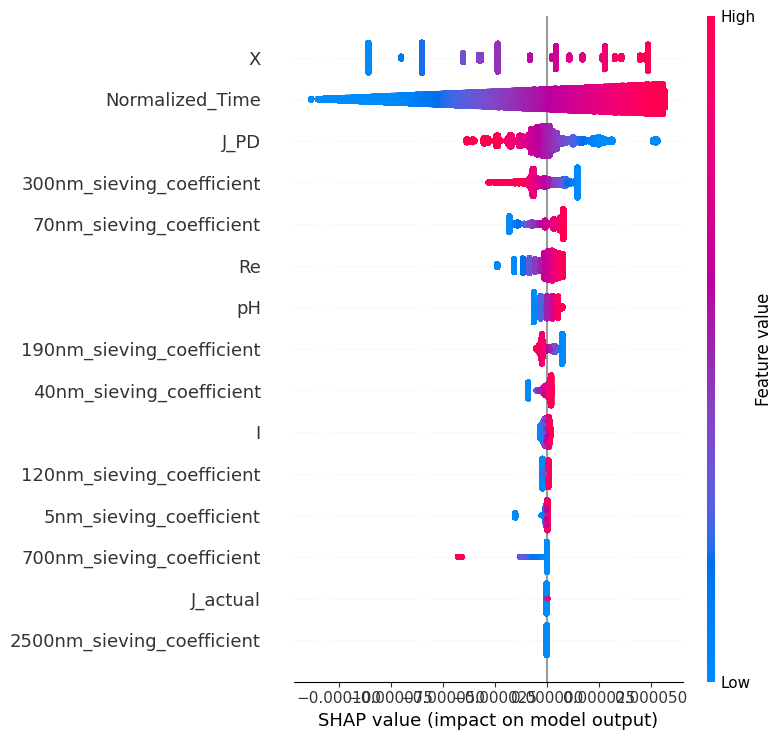

SHAP summary for output 120nm_retentate:


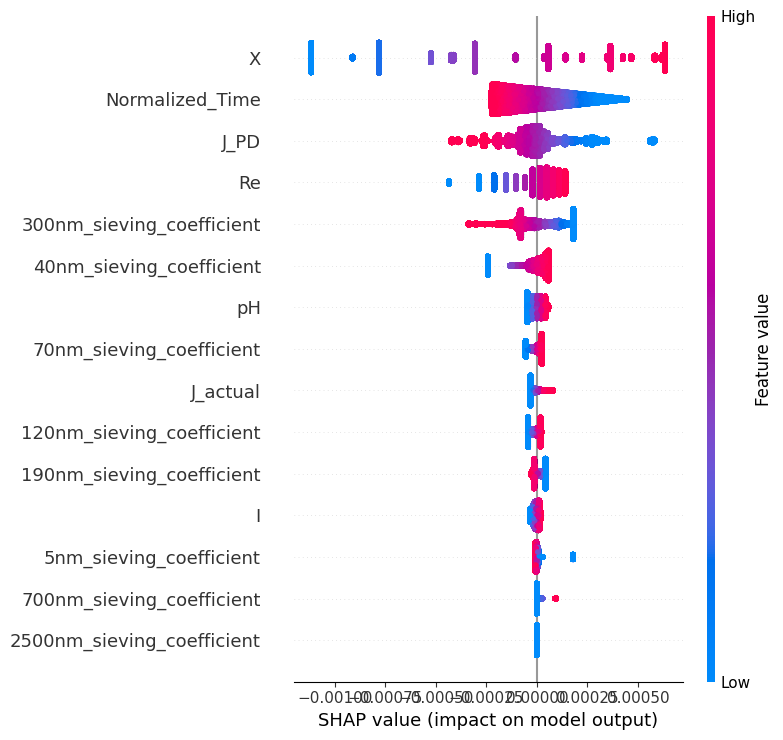

SHAP summary for output 120nm_permeate:


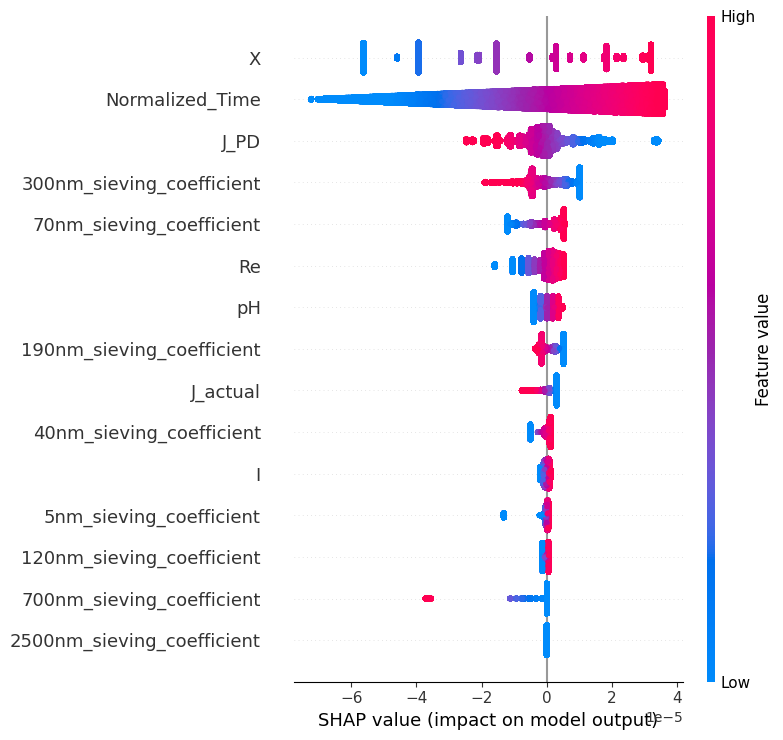

SHAP summary for output 190nm_retentate:


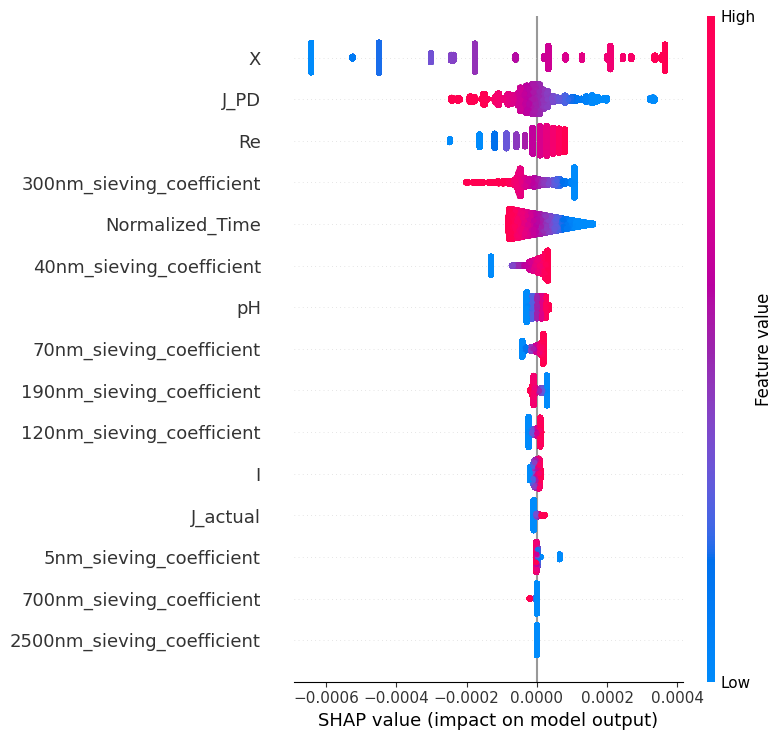

SHAP summary for output 190nm_permeate:


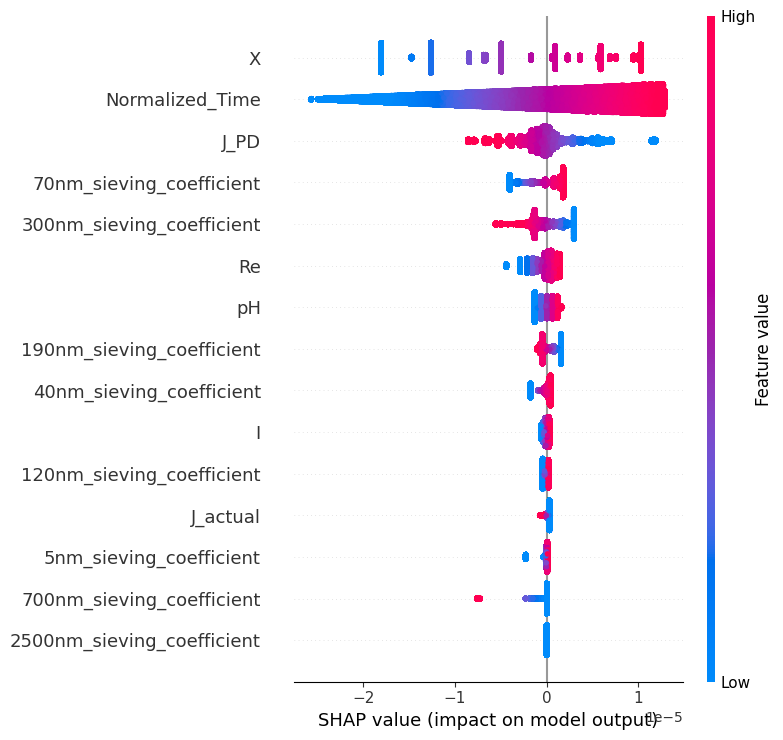

SHAP summary for output 300nm_retentate:


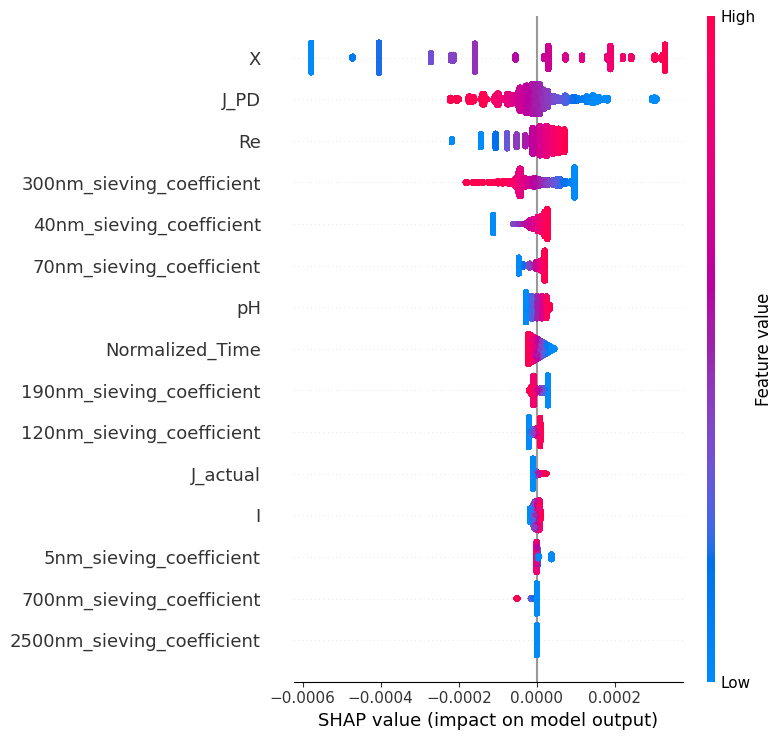

SHAP summary for output 300nm_permeate:


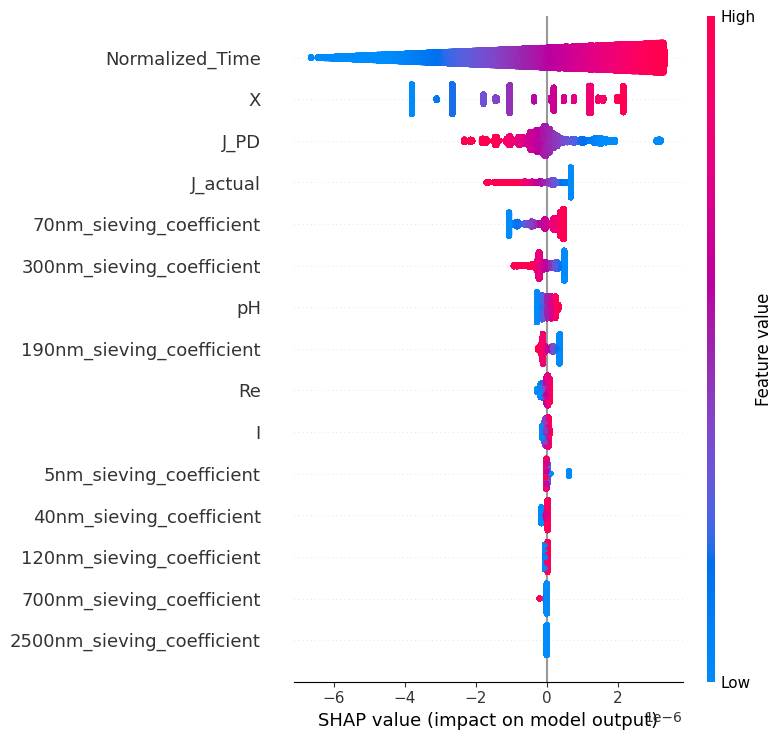

SHAP summary for output 700nm_retentate:


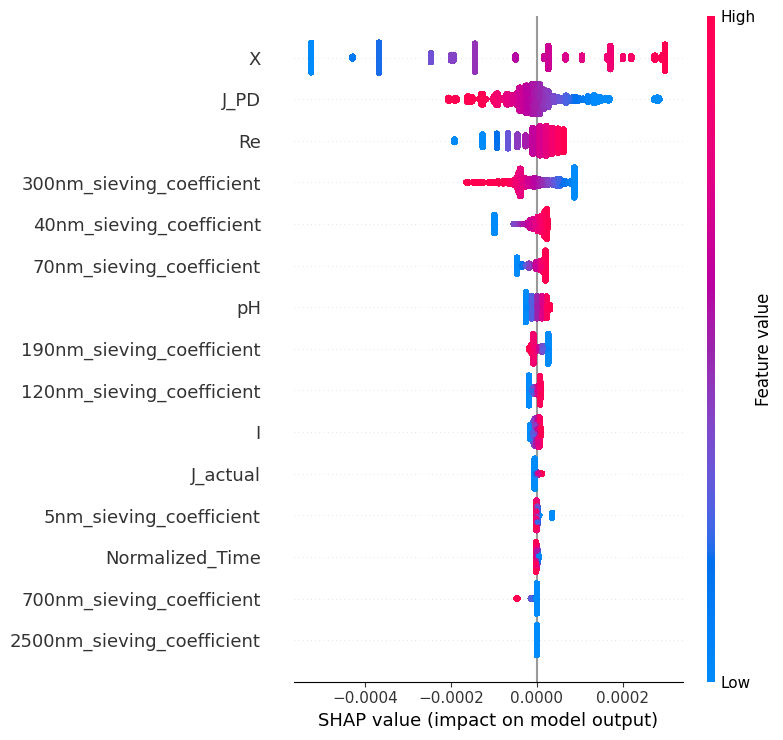

SHAP summary for output 700nm_permeate:


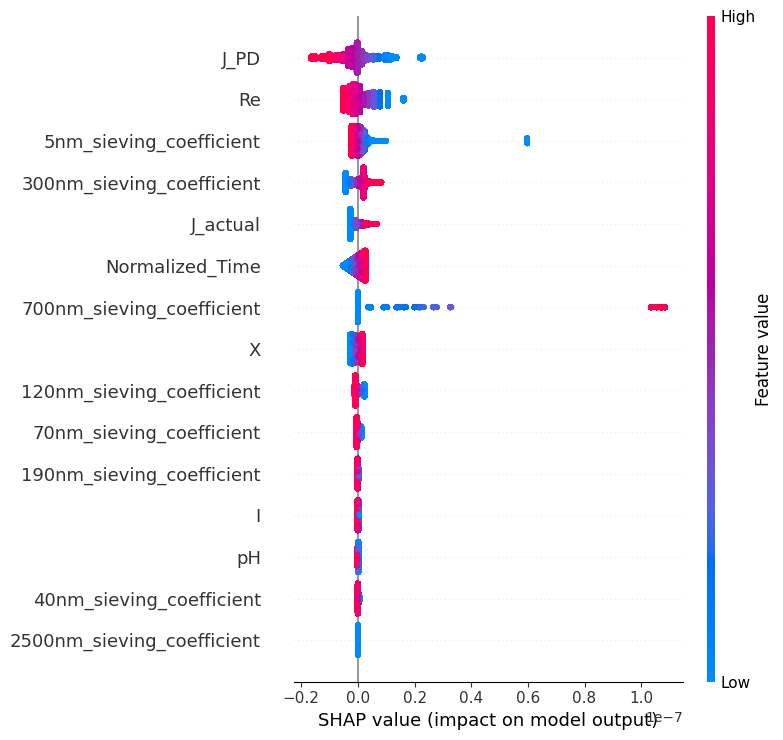

SHAP summary for output 2500nm_retentate:


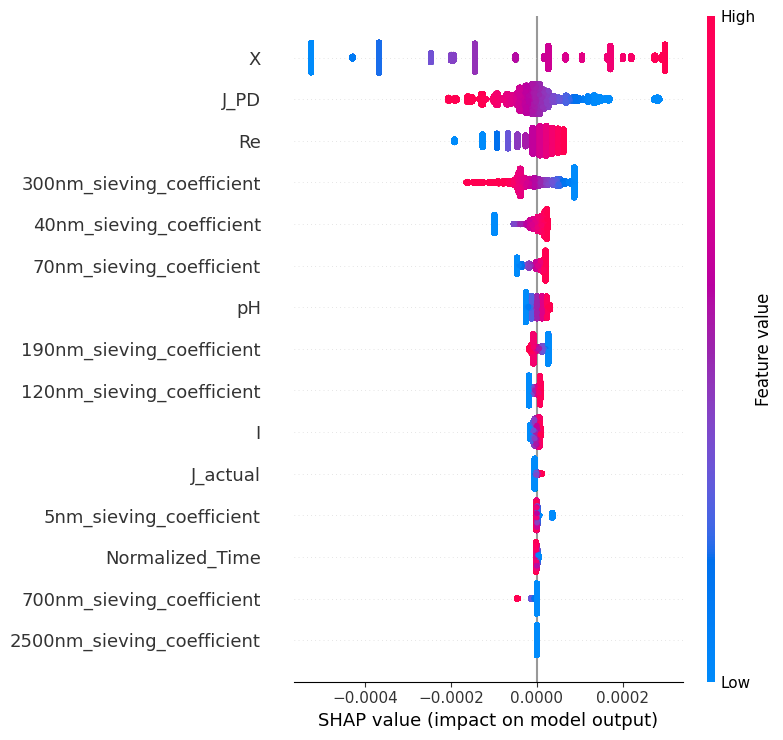

SHAP summary for output 2500nm_permeate:


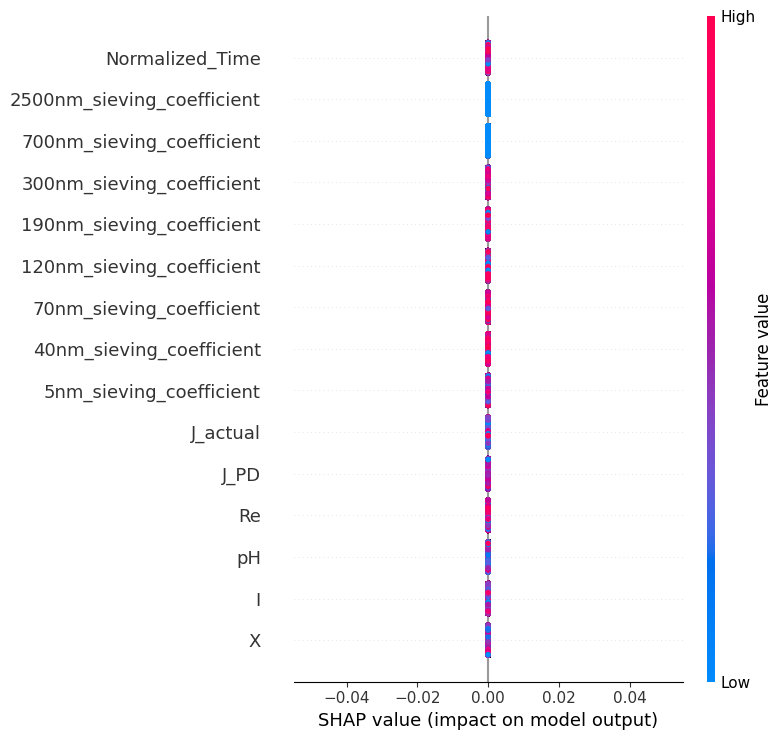

SHAP summary for output Diavolumes:


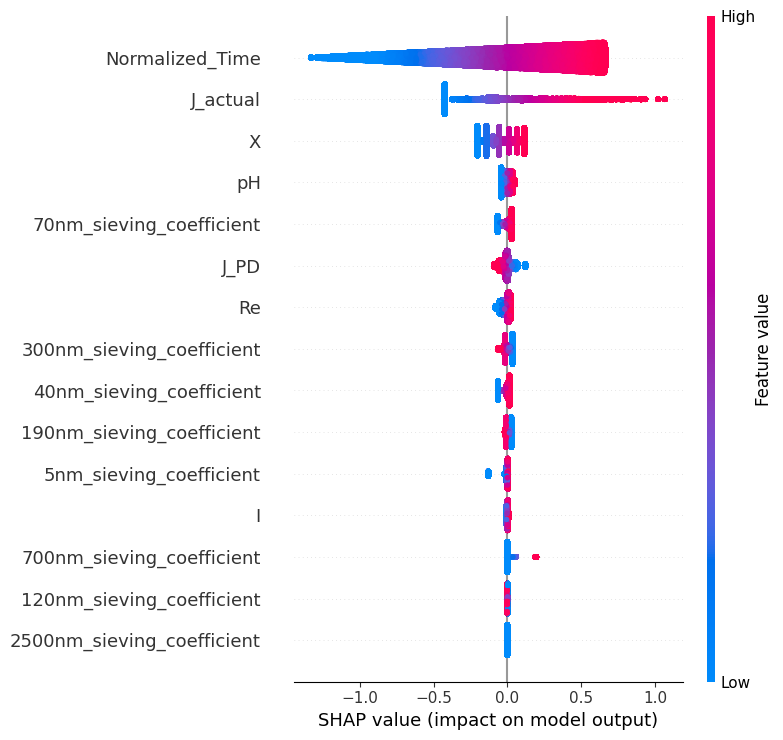

In [5]:
import shap
from sklearn.cluster import KMeans

# Check dimensions
print("X_train_fold_scaled shape:", X_train_fold_scaled.shape)
print("X_test_scaled shape:", X_test_scaled.shape)

# Use the cluster centers as the background data for SHAP
explainer = shap.LinearExplainer(pls_model_sqrt, X_train_fold_scaled)

# Compute SHAP values for the test data
shap_values = explainer.shap_values(X_test_scaled)

# Check dimensions of SHAP values
print("shap_values shape:", shap_values.shape)
Y_name =Y.columns
X_names=['X', 'I', 'pH', 'Re', 'J PD', 'J ', '5nm So', '40nm So',
       '70nm So', '120nm So', '190nm So', '300nm So', '700nm So', '2500nm So',
       'Normalized Time']
# Ensure feature names match the number of features in shap_values
for i in range(shap_values.shape[2]):
    print(f"SHAP summary for output {Y_name[i]}:")
    shap.summary_plot(shap_values[:, :, i], X_test_scaled, feature_names=X_names, max_display=5)

In [4]:
import shap
from sklearn.cluster import KMeans

# Check dimensions
print("X_train_fold_scaled shape:", X_train_fold_scaled.shape)
print("X_test_scaled shape:", X_test_scaled.shape)

# Use the cluster centers as the background data for SHAP
explainer = shap.LinearExplainer(pls_model_sqrt, X_train_fold_scaled)

# Compute SHAP values for the test data
shap_values = explainer.shap_values(X_test_scaled)

# Check dimensions of SHAP values

Y_name =Y.columns
X_names=['X', 'I', 'pH', 'Re', 'J PD', 'J ', '5nm So', '40nm So',
       '70nm So', '120nm So', '190nm So', '300nm So', '700nm So', '2500nm So',
       'Normalized Time']


/Users/baochikhuc/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


X_train_fold_scaled shape: (2454114, 15)
X_test_scaled shape: (758608, 15)


SHAP summary for output 5nm_retentate:


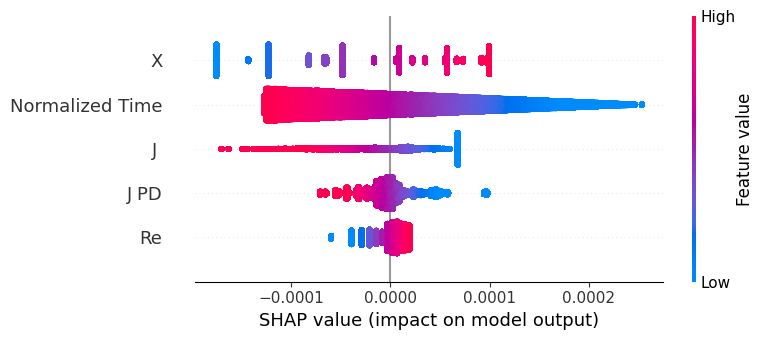

SHAP summary for output 5nm_permeate:


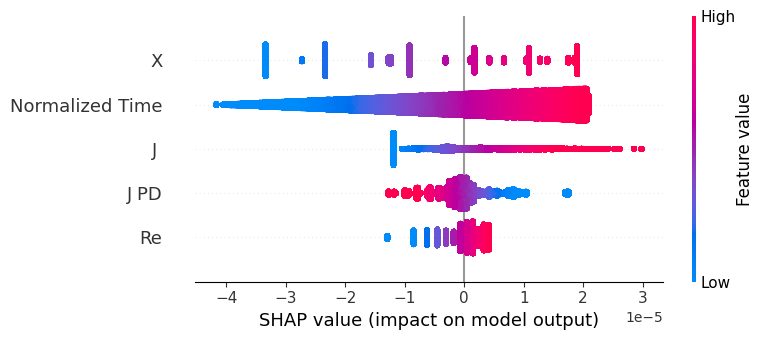

SHAP summary for output 40nm_retentate:


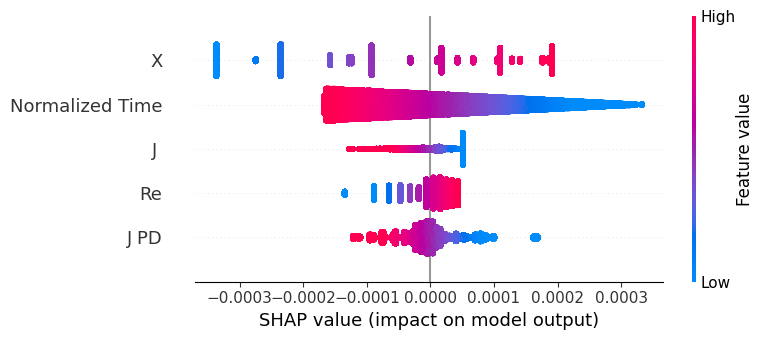

SHAP summary for output 40nm_permeate:


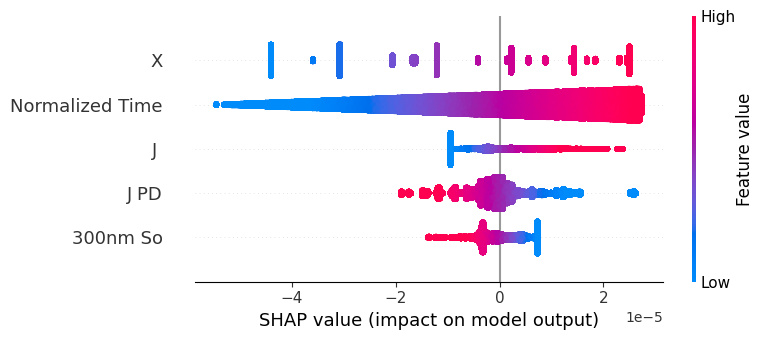

SHAP summary for output 70nm_retentate:


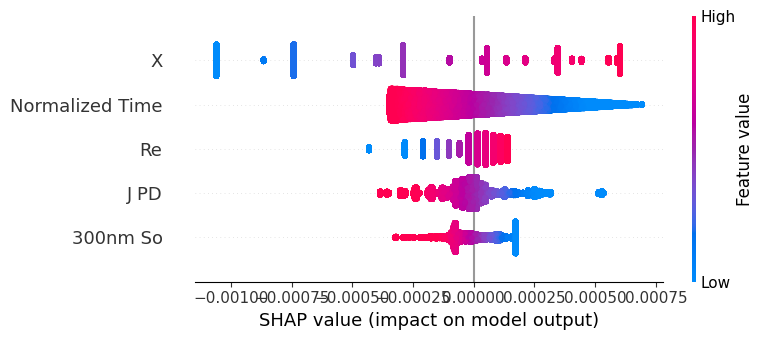

SHAP summary for output 70nm_permeate:


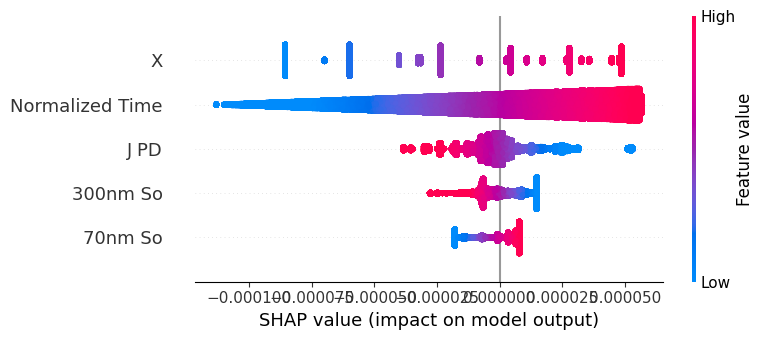

SHAP summary for output 120nm_retentate:


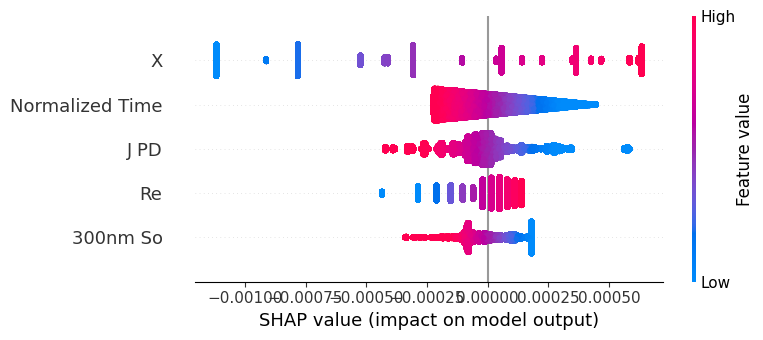

SHAP summary for output 120nm_permeate:


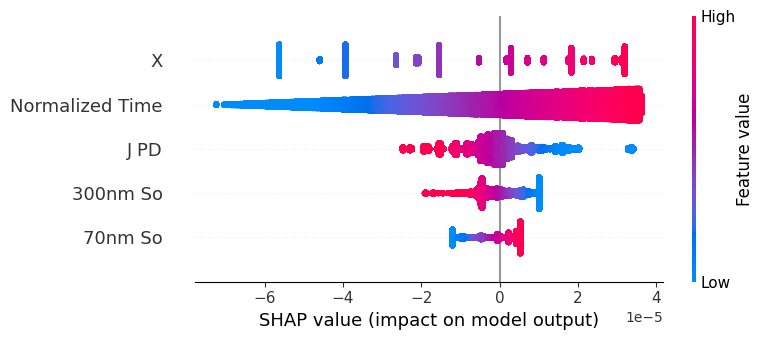

SHAP summary for output 190nm_retentate:


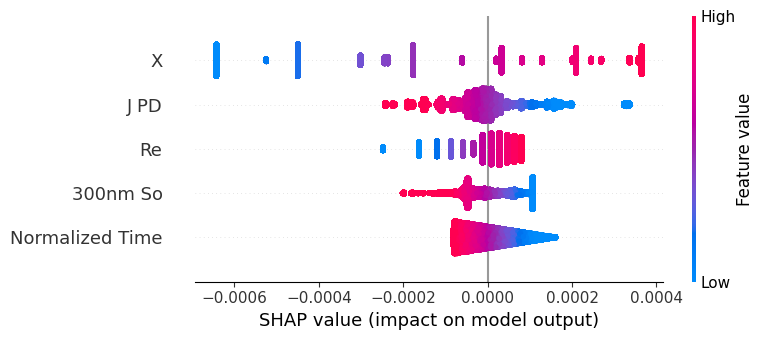

SHAP summary for output 190nm_permeate:


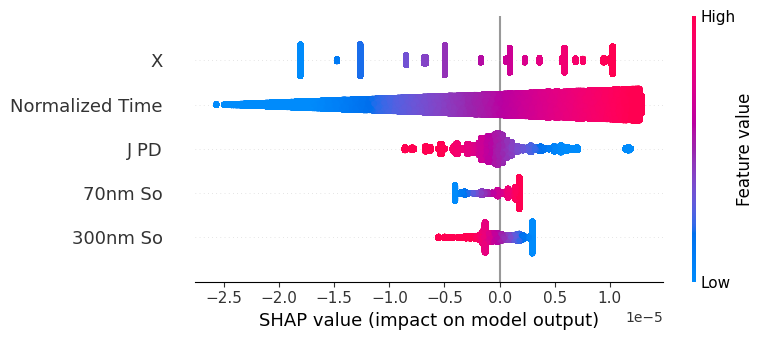

SHAP summary for output 300nm_retentate:


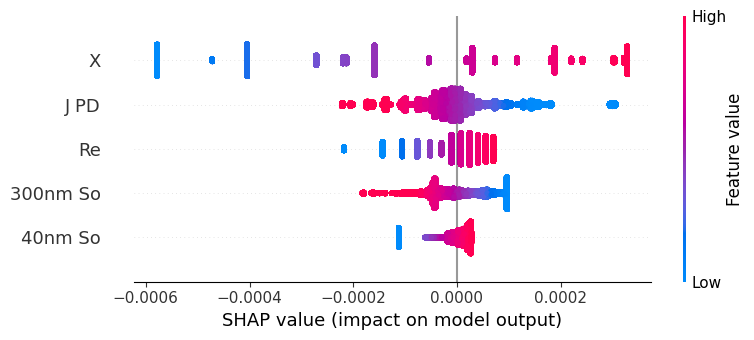

SHAP summary for output 300nm_permeate:


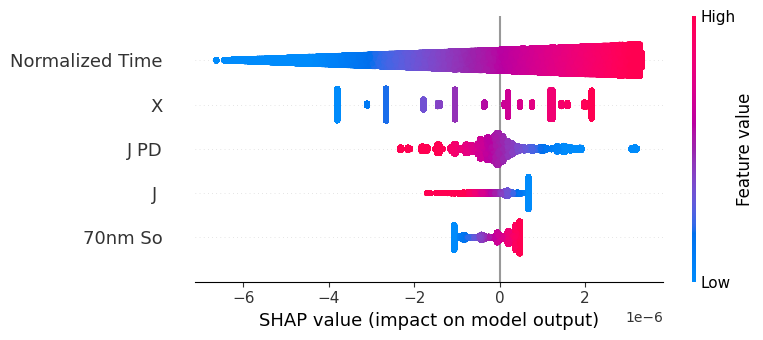

SHAP summary for output 700nm_retentate:


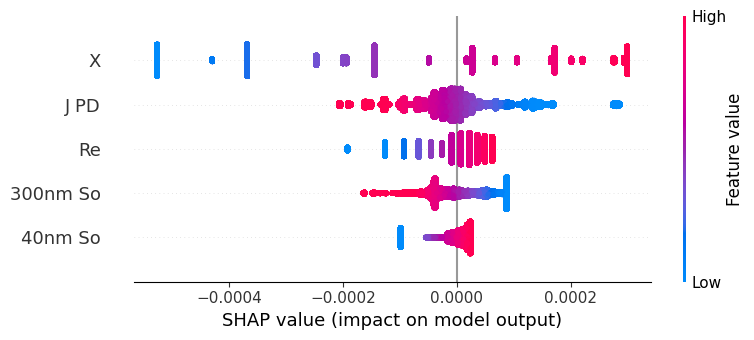

SHAP summary for output 700nm_permeate:


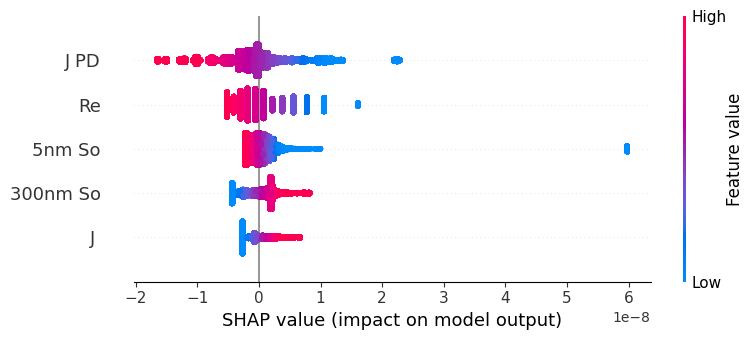

SHAP summary for output 2500nm_retentate:


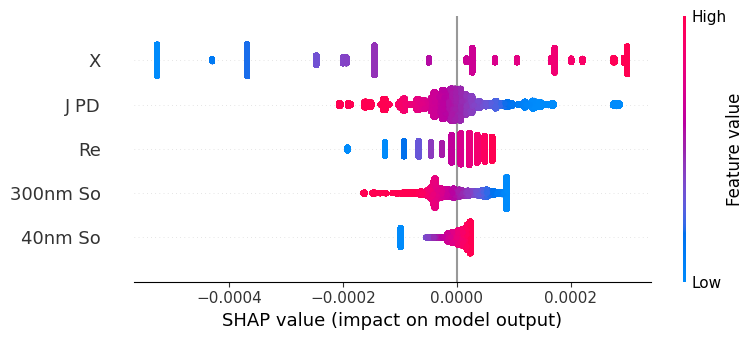

SHAP summary for output 2500nm_permeate:


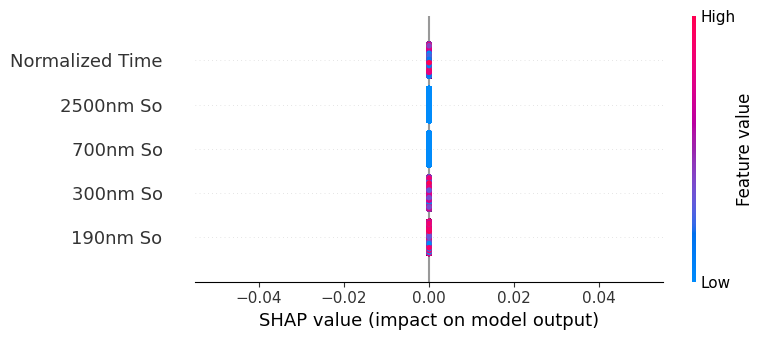

SHAP summary for output Diavolumes:


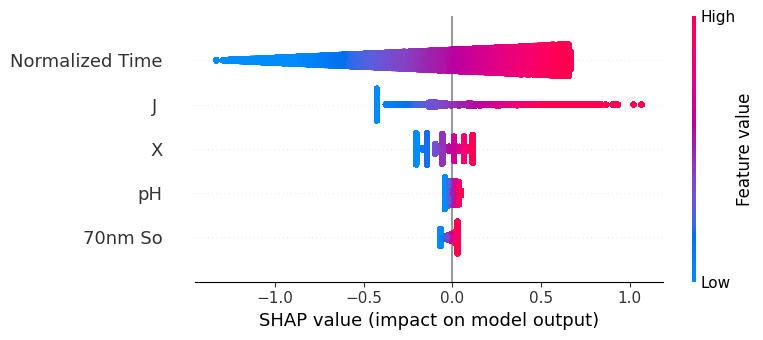

In [52]:
X_names=['X', 'I', 'pH', 'Re', 'J PD', 'J ', '5nm So', '40nm So',
       '70nm So', '120nm So', '190nm So', '300nm So', '700nm So', '2500nm So',
       'Normalized Time']
# Ensure feature names match the number of features in shap_values
for i in range(shap_values.shape[2]):
    print(f"SHAP summary for output {Y_name[i]}:")
    shap.summary_plot(shap_values[:, :, i], X_test_scaled, feature_names=X_names, max_display=5)

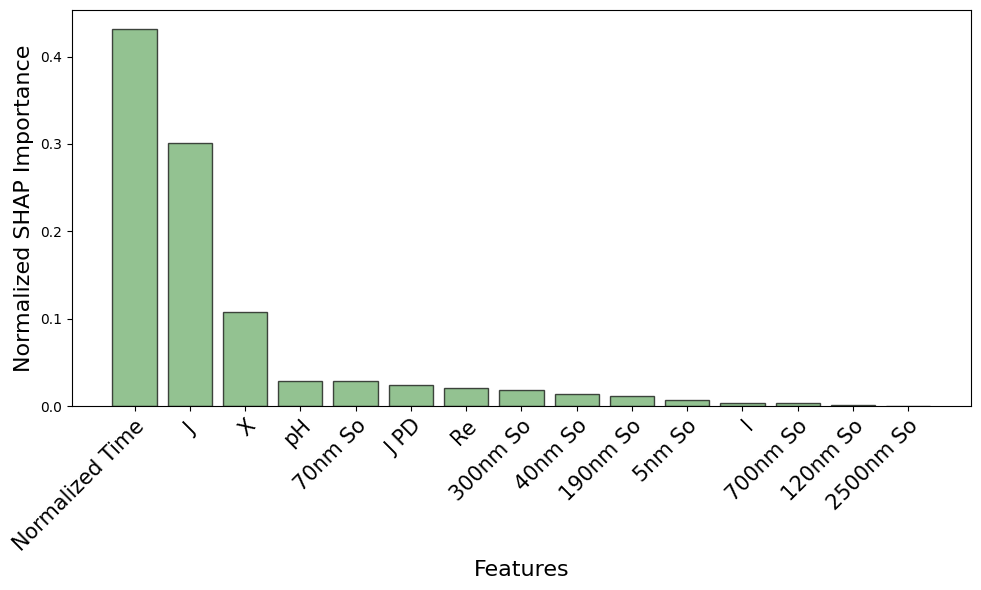

In [8]:
import numpy as np
import matplotlib.pyplot as plt
# Compute global SHAP importance
shap_importance = np.abs(shap_values).mean(axis=(0, 2))  # Mean across samples and outputs
# Normalize SHAP importance
shap_importance_normalized = shap_importance / shap_importance.sum()
X_names=['X', 'I', 'pH', 'Re', 'J PD', 'J ', '5nm So', '40nm So',
       '70nm So', '120nm So', '190nm So', '300nm So', '700nm So', '2500nm So',
       'Normalized Time']

X.columns = X_names
# Create a bar plot
plt.figure(figsize=(10, 6))
sorted_indices = np.argsort(shap_importance_normalized)[::-1]
plt.bar(X.columns[sorted_indices], shap_importance_normalized[sorted_indices], color='#66a862', alpha=0.7, edgecolor='black')
plt.xlabel('Features',fontsize = 16)
plt.ylabel('Normalized SHAP Importance', fontsize = 16)

plt.xticks(rotation=45, rotation_mode='anchor', ha='right',fontsize=15)# Rotate feature names for better readability
plt.tight_layout()
plt.savefig('shap_importance_sqrt.png' ,dpi=300)
plt.show()


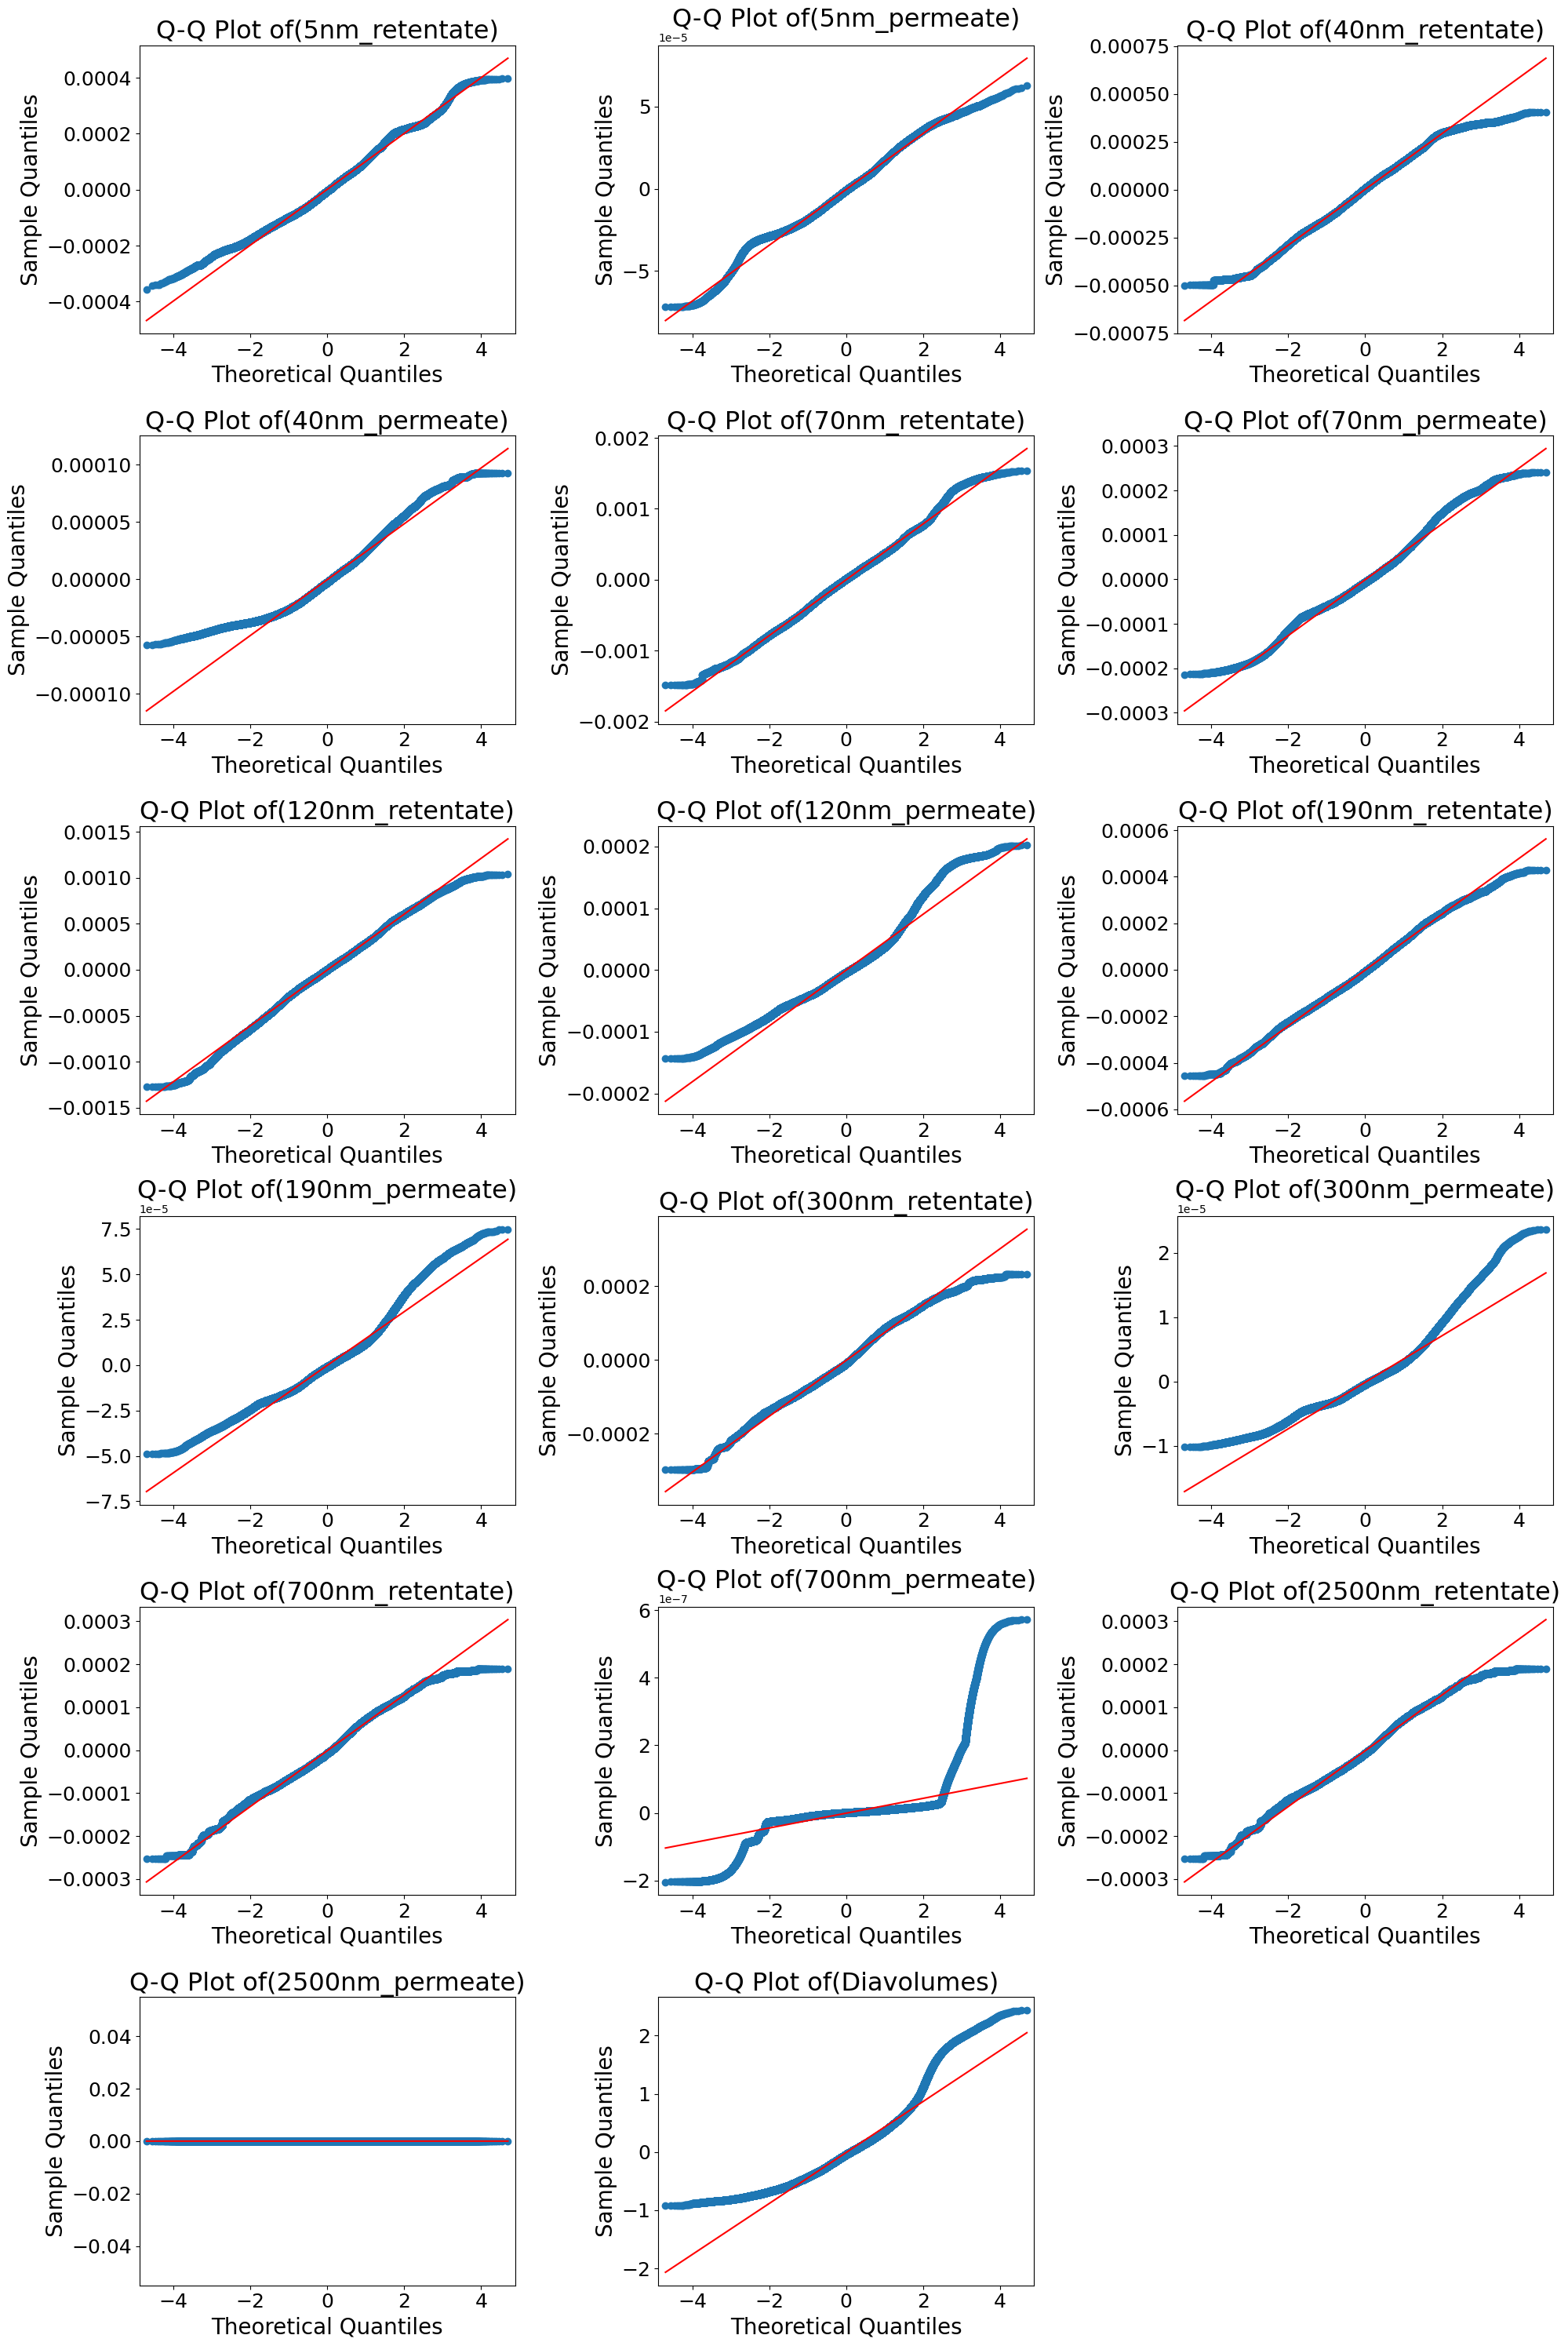

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
import pandas as pd

# Example: Replace with your actual residuals (ensure residuals is a Pandas DataFrame)
# Y_test should be a DataFrame with columns corresponding to your target variables
residuals = Y_test-Y_test_pred  # Replace Y_test with your actual residuals DataFrame

# Dynamically calculate rows and columns for subplots
num_targets = residuals.shape[1]
n_rows = (num_targets // 3) + (1 if num_targets % 3 > 0 else 0)  # Adjust rows dynamically

fig, axes = plt.subplots(n_rows, 3, figsize=(20, 5 * n_rows))  # Adjust height dynamically
axes = axes.flatten()  # Flatten axes for easier iteration

# Plot Q-Q plots for each target
for i, column in enumerate(residuals.columns):
    qqplot(residuals[column], line='s', ax=axes[i])

    axes[i].set_title(f'Q-Q Plot of({column})', fontsize=23)
    axes[i].set_xlabel('Theoretical Quantiles', fontsize=20)
    axes[i].set_ylabel('Sample Quantiles', fontsize=20)
    axes[i].tick_params(axis='both', which='major', labelsize=18)
 
   

# Remove empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


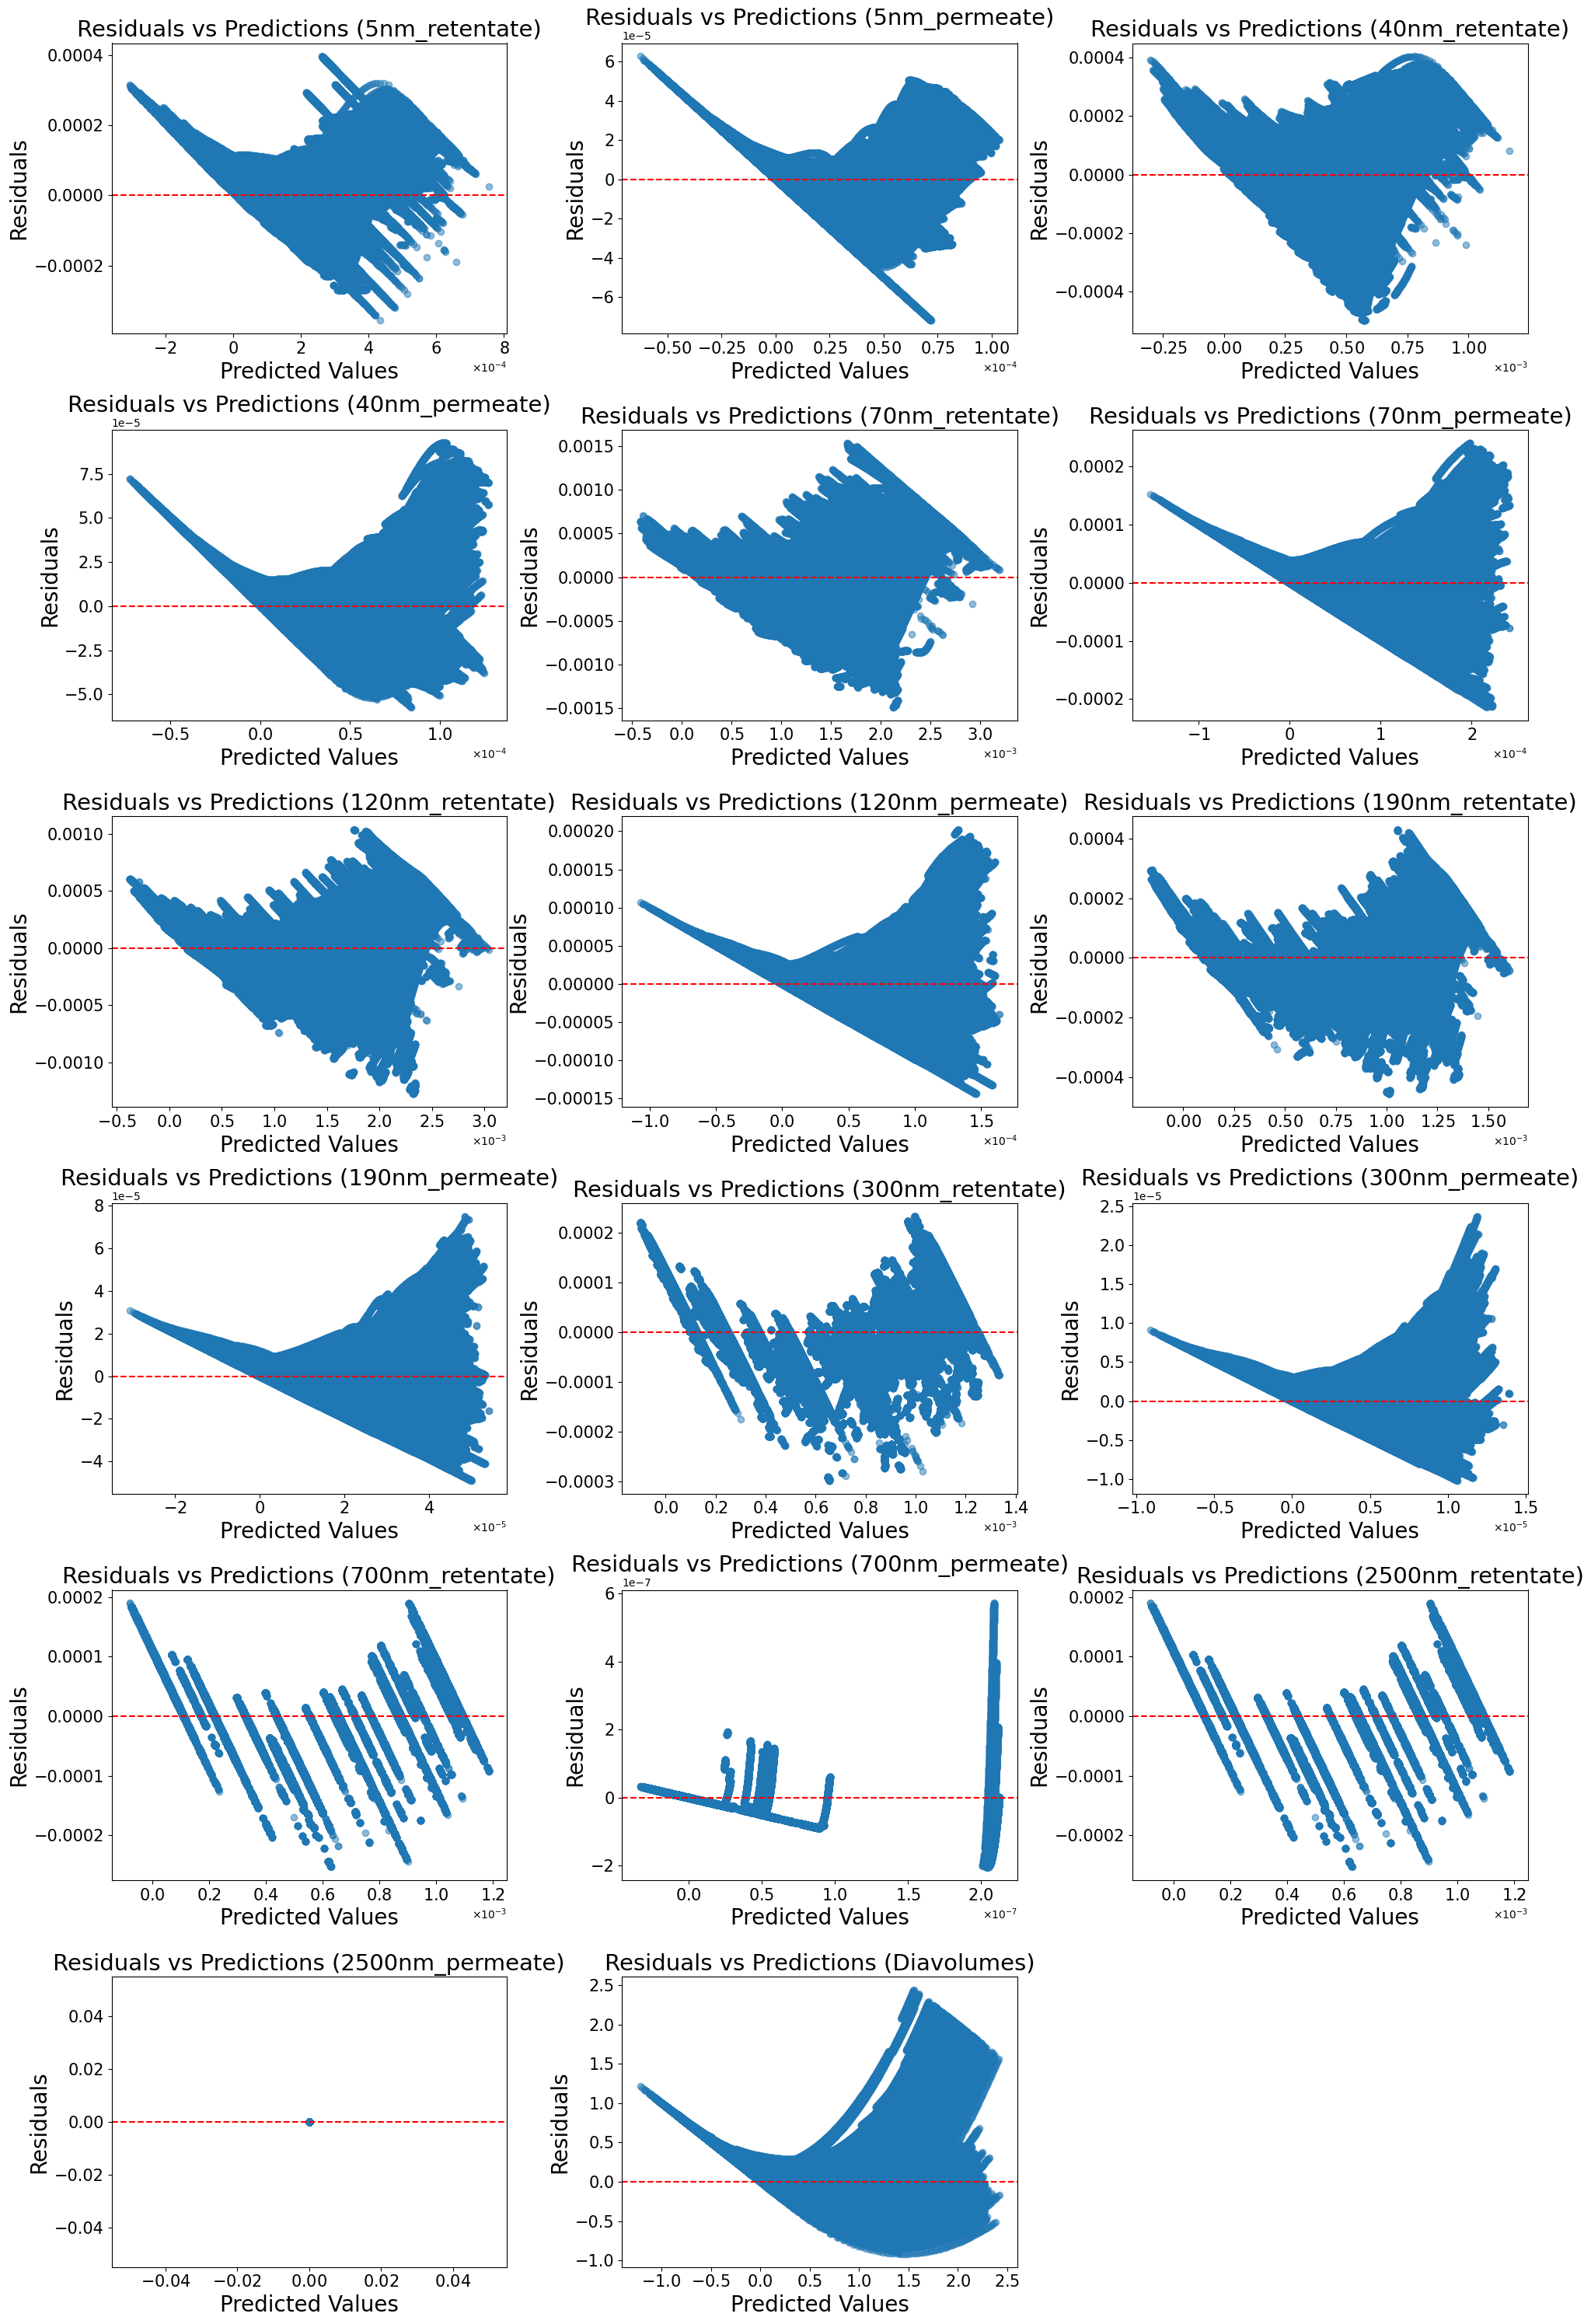

In [28]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

residuals = pd.DataFrame(residuals, columns=Y.columns)
# Number of targets
num_targets = residuals.shape[1]

# Create subplots
fig, axes = plt.subplots(nrows=(num_targets // 3) + (1 if num_targets % 3 > 0 else 0), ncols=3, figsize=(20, 5 * ((num_targets // 3) + (1 if num_targets % 3 > 0 else 0))))
axes = axes.flatten()

# Plot residuals vs predicted values for each target
for i, column in enumerate(residuals.columns):
    axes[i].scatter(Y_test_pred[:, i], residuals[column], alpha=0.5)
    axes[i].axhline(y=0, color='r', linestyle='--')
    axes[i].set_title(f'Residuals vs Predictions ({column})',fontsize=21)
    axes[i].set_xlabel('Predicted Values',fontsize=20)
    axes[i].set_ylabel('Residuals',fontsize = 20)
  
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_powerlimits((-3, 3))  # Automatically switches to scientific notation
    axes[i].xaxis.set_major_formatter(formatter)

    # Move scientific notation exponent to the axis label
    axes[i].ticklabel_format(style='sci', axis='x', scilimits=(-3, 3))
    axes[i].tick_params(axis='both', which='major', labelsize=15)

    

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [4]:
import numpy as np
from scipy.interpolate import griddata
import pandas as pd
# Load the dataset
data = pd.read_csv('/Users/baochikhuc/Documents/Data_GFP/Processed Data with Selectivity/last_rows_processed.csv')

# Extract columns X, Re, and J_PD
X = data['X'].values
Re = data['Re'].values
J_PD = data['J_PD'].values


# Create interpolation function
def predict_j_pd(x, re):
    points = np.array([X, Re]).T
    values = np.array(J_PD)
    return griddata(points, values, (x, re), method='linear')

33.1
17.57


In [70]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import GroupKFold, GroupShuffleSplit
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np



# Apply log transformation to all features
X_sqrt = np.sqrt(X)
Y_sqrt = np.sqrt(np.where(Y < 0, 0, Y))



# Define the number of components for PLS
n_components = 5

# Split data into train-validation and test sets
# group_split = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_val_idx, test_idx = next(group_split.split(X_sqrt, Y_sqrt, groups))

X_train_val, X_test = X_sqrt.iloc[train_val_idx], X_sqrt.iloc[test_idx]
Y_train_val, Y_test = Y_sqrt[train_val_idx], Y_sqrt[test_idx]
groups_train_val = groups.iloc[train_val_idx]

# Initialize scalers
feature_scaler = StandardScaler()
target_scaler = StandardScaler()

# Set up 5-fold cross-validation
n_folds = 5
group_kfold = GroupKFold(n_splits=n_folds)

# Initialize placeholders for aggregate metrics
validation_q2_list, validation_r2_list = [], []
validation_mae_list, validation_mape_list = [], []
validation_mse_list, validation_rmse_list = [], []

# Cross-validation loop
for fold, (train_idx, val_idx) in enumerate(group_kfold.split(X_train_val, Y_train_val, groups_train_val), start=1):
    # Split data
    X_train_fold, X_val_fold = X_train_val.iloc[train_idx], X_train_val.iloc[val_idx]
    Y_train_fold, Y_val_fold = Y_train_val[train_idx], Y_train_val[val_idx]

    # Scale data
    X_train_fold_scaled = feature_scaler.fit_transform(X_train_fold)
    Y_train_fold_scaled = target_scaler.fit_transform(Y_train_fold)
    X_val_fold_scaled = feature_scaler.transform(X_val_fold)
    Y_val_fold_scaled = target_scaler.transform(Y_val_fold)

    # Train the model
    pls_model_sqrt_2= PLSRegression(n_components=n_components)
    pls_model_sqrt_2.fit(X_train_fold_scaled, Y_train_fold_scaled)

    # Predict on validation set
    Y_val_pred = pls_model_sqrt_2.predict(X_val_fold_scaled)
    
    Y_val_pred = target_scaler.inverse_transform(Y_val_pred)

    Y_val_pred = np.square(Y_val_pred)
    Y_val_fold = np.square(Y_val_fold)


    # Compute metrics only on valid data
    val_mse = mean_squared_error(Y_val_fold, Y_val_pred, multioutput='raw_values')
    val_rmse = np.sqrt(val_mse)
    val_r2 = r2_score(Y_val_fold, Y_val_pred, multioutput='uniform_average')
    val_mae = mean_absolute_error(Y_val_fold, Y_val_pred, multioutput='raw_values')

    

    # Aggregate metrics across folds
  
    validation_r2_list.append(val_r2)
    validation_mae_list.append(np.mean(val_mae))
    validation_mse_list.append(np.mean(val_mse))
    validation_rmse_list.append(np.mean(val_rmse))

# Compute averages across all folds for validation
# Compute averages across all folds for validation

avg_val_r2 = np.mean(validation_r2_list)
avg_val_mae = np.mean(validation_mae_list)
avg_val_mse = np.mean(validation_mse_list)
avg_val_rmse = np.mean(validation_rmse_list)

# Print validation results
print(f"\nValidation Results (Averaged Across Folds):")

print(f"  R²: {avg_val_r2:.7f}")
print(f"  MAE: {avg_val_mae:.7f}")
print(f"  MSE: {avg_val_mse:.7f}")
print(f"  RMSE: {avg_val_rmse:.7f}")

# Compute metrics per target for validation
print("\nValidation Metrics Per Target:")
for i, target in enumerate(Y.columns):
    target_val_r2 = r2_score(Y_val_fold[:, i], Y_val_pred[:, i])
    target_val_mse = mean_squared_error(Y_val_fold[:, i], Y_val_pred[:, i])
    target_val_rmse = np.sqrt(target_val_mse)
    target_val_mae = mean_absolute_error(Y_val_fold[:, i], Y_val_pred[:, i])

    print(f"Target: {target}")
    print(f"  R²: {target_val_r2:.7f}")

    print(f"  MAE: {target_val_mae:.7f}")
    print(f"  MSE: {target_val_mse:.7f}")
    print(f"  RMSE: {target_val_rmse:.7f}")

X_test_scaled = feature_scaler.transform(X_test)
Y_test_scaled = target_scaler.transform(Y_test)

# Evaluate on test set
Y_test_pred = pls_model_sqrt_2.predict(X_test_scaled)
Y_test_pred = target_scaler.inverse_transform(Y_test_pred)

Y_test_pred = np.square(Y_test_pred)
Y_test = np.square(Y_test)

# Compute metrics for test set
test_mse = mean_squared_error(Y_test, Y_test_pred, multioutput='raw_values')
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(Y_test, Y_test_pred, multioutput='uniform_average')
test_mae = mean_absolute_error(Y_test, Y_test_pred, multioutput='raw_values')


# Print test results
print(f"\nTest Results:")

print(f"  R²: {test_r2:.7f}")
print(f"  MAE: {np.mean(test_mae):.7f}")
print(f"  MSE: {np.mean(test_mse):.7f}")
print(f"  RMSE: {np.mean(test_rmse):.7f}")




/Users/baochikhuc/Library/Python/3.9/lib/python/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/baochikhuc/Library/Python/3.9/lib/python/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Validation Results (Averaged Across Folds):
  R²: 0.7679075
  MAE: 0.0166994
  MSE: 0.0094640
  RMSE: 0.0236639

Validation Metrics Per Target:
Target: 5nm_retentate
  R²: 0.7627658
  MAE: 0.0000665
  MSE: 0.0000000
  RMSE: 0.0000903
Target: 5nm_permeate
  R²: 0.8254592
  MAE: 0.0000103
  MSE: 0.0000000
  RMSE: 0.0000137
Target: 40nm_retentate
  R²: 0.8031521
  MAE: 0.0000994
  MSE: 0.0000000
  RMSE: 0.0001286
Target: 40nm_permeate
  R²: 0.7681798
  MAE: 0.0000153
  MSE: 0.0000000
  RMSE: 0.0000206
Target: 70nm_retentate
  R²: 0.8087711
  MAE: 0.0002665
  MSE: 0.0000001
  RMSE: 0.0003628
Target: 70nm_permeate
  R²: 0.5997034
  MAE: 0.0000416
  MSE: 0.0000000
  RMSE: 0.0000590
Target: 120nm_retentate
  R²: 0.8822061
  MAE: 0.0001970
  MSE: 0.0000001
  RMSE: 0.0002752
Target: 120nm_permeate
  R²: 0.5310136
  MAE: 0.0000304
  MSE: 0.0000000
  RMSE: 0.0000441
Target: 190nm_retentate
  R²: 0.9511324
  MAE: 0.0000696
  MSE: 0.0000000
  RMSE: 0.0000967
Target: 190nm_permeate
  R²: 0.5286809


In [17]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import GroupKFold, GroupShuffleSplit
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

# # Add normalized time to the features
# def normalize_time_per_simulation(df, simulation_column, time_column):
# #     df['Normalized_Time'] = df.groupby(simulation_column)[time_column].transform(lambda x: x / x.max())
# #     return df

# # Apply the function to normalize time
sampled_data = normalize_time_per_simulation(sampled_data, simulation_column='Simulation_ID', time_column='Time (s)')

# Define features and targets
X = sampled_data.drop(columns=['Simulation_ID', 'Time (s)', 
                               '5nm_retentate', '5nm_permeate', '5nm_cumulative_yield', '5nm_size_solute',
                               '40nm_retentate', '40nm_permeate', '40nm_cumulative_yield', '40nm_size_solute',
                               '70nm_retentate', '70nm_permeate', '70nm_cumulative_yield', '70nm_size_solute',
                               '120nm_retentate', '120nm_permeate', '120nm_cumulative_yield', '120nm_size_solute',
                               '190nm_retentate', '190nm_permeate', '190nm_cumulative_yield', '190nm_size_solute',
                               '300nm_retentate', '300nm_permeate', '300nm_cumulative_yield', '300nm_size_solute',
                               '700nm_retentate', '700nm_permeate', '700nm_cumulative_yield', '700nm_size_solute',
                               '2500nm_retentate', '2500nm_permeate', '2500nm_cumulative_yield', '2500nm_size_solute',
                               'Diavolumes', '2500nm_sieving_coefficient', '120nm_sieving_coefficient'])

# Apply log transformation to all features
X_sqrt = np.sqrt(X)
Y_sqrt = np.sqrt(np.where(Y < 0, 0, Y))

# # Define target variables
# Y = sampled_data[['5nm_retentate', '5nm_permeate',
#                   '40nm_retentate', '40nm_permeate', 
#                   '70nm_retentate', '70nm_permeate',   
#                   '120nm_retentate', '120nm_permeate',  
#                   '190nm_retentate', '190nm_permeate', 
#                   '300nm_retentate', '300nm_permeate', 
#                   '700nm_retentate', '700nm_permeate', 
#                   '2500nm_retentate', '2500nm_permeate',
#                   'Diavolumes']]

# Apply log transformation to targets

# groups = sampled_data['Simulation_ID']

# Define the number of components for PLS
n_components = 5

# Split data into train-validation and test sets
# group_split = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_val_idx, test_idx = next(group_split.split(X_sqrt, Y_sqrt, groups))

X_train_val, X_test = X_sqrt.iloc[train_val_idx], X_sqrt.iloc[test_idx]
Y_train_val, Y_test = Y_sqrt[train_val_idx], Y_sqrt[test_idx]
groups_train_val = groups.iloc[train_val_idx]

# Initialize scalers
feature_scaler = StandardScaler()
target_scaler = StandardScaler()

# Set up 5-fold cross-validation
n_folds = 5
group_kfold = GroupKFold(n_splits=n_folds)

# Initialize placeholders for aggregate metrics
validation_q2_list, validation_r2_list = [], []
validation_mae_list, validation_mape_list = [], []
validation_mse_list, validation_rmse_list = [], []

# Cross-validation loop
for fold, (train_idx, val_idx) in enumerate(group_kfold.split(X_train_val, Y_train_val, groups_train_val), start=1):
    # Split data
    X_train_fold, X_val_fold = X_train_val.iloc[train_idx], X_train_val.iloc[val_idx]
    Y_train_fold, Y_val_fold = Y_train_val[train_idx], Y_train_val[val_idx]

    # Scale data
    X_train_fold_scaled = feature_scaler.fit_transform(X_train_fold)
    Y_train_fold_scaled = target_scaler.fit_transform(Y_train_fold)
    X_val_fold_scaled = feature_scaler.transform(X_val_fold)
    Y_val_fold_scaled = target_scaler.transform(Y_val_fold)

    # Train the model
    pls_model_sqrt_2_add= PLSRegression(n_components=n_components)
    pls_model_sqrt_2_add.fit(X_train_fold_scaled, Y_train_fold_scaled)

    # Predict on validation set
    Y_val_pred = pls_model_sqrt_2_add.predict(X_val_fold_scaled)
    
    Y_val_pred = target_scaler.inverse_transform(Y_val_pred)

    Y_val_pred = np.square(Y_val_pred)
    Y_val_fold = np.square(Y_val_fold)


    # Compute metrics only on valid data
    val_mse = mean_squared_error(Y_val_fold, Y_val_pred, multioutput='raw_values')
    val_rmse = np.sqrt(val_mse)
    val_r2 = r2_score(Y_val_fold, Y_val_pred, multioutput='uniform_average')
    val_mae = mean_absolute_error(Y_val_fold, Y_val_pred, multioutput='raw_values')

    

    # Aggregate metrics across folds
  
    validation_r2_list.append(val_r2)
    validation_mae_list.append(np.mean(val_mae))
    validation_mse_list.append(np.mean(val_mse))
    validation_rmse_list.append(np.mean(val_rmse))

# Compute averages across all folds for validation
# Compute averages across all folds for validation
avg_val_q2 = np.mean(validation_q2_list)
avg_val_r2 = np.mean(validation_r2_list)
avg_val_mae = np.mean(validation_mae_list)
avg_val_mse = np.mean(validation_mse_list)
avg_val_rmse = np.mean(validation_rmse_list)

# Print validation results
print(f"\nValidation Results (Averaged Across Folds):")

print(f"  R²: {avg_val_r2:.7f}")
print(f"  MAE: {avg_val_mae:.7f}")
print(f"  MSE: {avg_val_mse:.7f}")
print(f"  RMSE: {avg_val_rmse:.7f}")

# Compute metrics per target for validation
print("\nValidation Metrics Per Target:")
for i, target in enumerate(Y.columns):
    target_val_r2 = r2_score(Y_val_fold[:, i], Y_val_pred[:, i])
    target_val_mse = mean_squared_error(Y_val_fold[:, i], Y_val_pred[:, i])
    target_val_rmse = np.sqrt(target_val_mse)
    target_val_mae = mean_absolute_error(Y_val_fold[:, i], Y_val_pred[:, i])

    print(f"Target: {target}")
    print(f"  R²: {target_val_r2:.7f}")

    print(f"  MAE: {target_val_mae:.7f}")
    print(f"  MSE: {target_val_mse:.7f}")
    print(f"  RMSE: {target_val_rmse:.7f}")

X_test_scaled = feature_scaler.transform(X_test)
Y_test_scaled = target_scaler.transform(Y_test)

# Evaluate on test set
Y_test_pred = pls_model_sqrt_2_add.predict(X_test_scaled)
Y_test_pred_copy = Y_test_pred
Y_test_pred = target_scaler.inverse_transform(Y_test_pred)

Y_test_pred = np.square(Y_test_pred)
Y_test_copy = Y_test
Y_test = np.square(Y_test)

# Compute metrics for test set
test_mse = mean_squared_error(Y_test, Y_test_pred, multioutput='raw_values')
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(Y_test, Y_test_pred, multioutput='uniform_average')
test_mae = mean_absolute_error(Y_test, Y_test_pred, multioutput='raw_values')


# Print test results
print(f"\nTest Results:")

print(f"  R²: {test_r2:.7f}")
print(f"  MAE: {np.mean(test_mae):.7f}")
print(f"  MSE: {np.mean(test_mse):.7f}")
print(f"  RMSE: {np.mean(test_rmse):.7f}")

# # Compute metrics per target for test
print("\nTest Metrics Per Target:")
for i, target in enumerate(Y.columns):
    target_test_r2 = r2_score(Y_test[:, i], Y_test_pred[:, i])
    target_test_mse = mean_squared_error(Y_test[:, i], Y_test_pred[:, i])
    target_test_rmse = np.sqrt(target_test_mse)
    target_test_mae = mean_absolute_error(Y_test[:, i], Y_test_pred[:, i])
    
    print(f"Target: {target}")
    print(f"  R²: {target_test_r2:.7f}")

    print(f"  MAE: {target_test_mae:.7f}")
    print(f"  MSE: {target_test_mse:.7f}")
    print(f"  RMSE: {target_test_rmse:.7f}")


/Users/baochikhuc/Library/Python/3.9/lib/python/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/baochikhuc/Library/Python/3.9/lib/python/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Validation Results (Averaged Across Folds):
  R²: 0.7677665
  MAE: 0.0166490
  MSE: 0.0094389
  RMSE: 0.0236330

Validation Metrics Per Target:
Target: 5nm_retentate
  R²: 0.7625428
  MAE: 0.0000665
  MSE: 0.0000000
  RMSE: 0.0000904
Target: 5nm_permeate
  R²: 0.8272835
  MAE: 0.0000102
  MSE: 0.0000000
  RMSE: 0.0000137
Target: 40nm_retentate
  R²: 0.8025498
  MAE: 0.0000995
  MSE: 0.0000000
  RMSE: 0.0001288
Target: 40nm_permeate
  R²: 0.7677019
  MAE: 0.0000153
  MSE: 0.0000000
  RMSE: 0.0000206
Target: 70nm_retentate
  R²: 0.8082496
  MAE: 0.0002667
  MSE: 0.0000001
  RMSE: 0.0003633
Target: 70nm_permeate
  R²: 0.5976283
  MAE: 0.0000417
  MSE: 0.0000000
  RMSE: 0.0000592
Target: 120nm_retentate
  R²: 0.8818992
  MAE: 0.0001972
  MSE: 0.0000001
  RMSE: 0.0002755
Target: 120nm_permeate
  R²: 0.5283461
  MAE: 0.0000304
  MSE: 0.0000000
  RMSE: 0.0000443
Target: 190nm_retentate
  R²: 0.9505389
  MAE: 0.0000699
  MSE: 0.0000000
  RMSE: 0.0000973
Target: 190nm_permeate
  R²: 0.5276680


In [29]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import GroupKFold, GroupShuffleSplit
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

# # Add normalized time to the features
# def normalize_time_per_simulation(df, simulation_column, time_column):
# #     df['Normalized_Time'] = df.groupby(simulation_column)[time_column].transform(lambda x: x / x.max())
# #     return df

# # Apply the function to normalize time
sampled_data = normalize_time_per_simulation(sampled_data, simulation_column='Simulation_ID', time_column='Time (s)')

# Define features and targets
X = sampled_data.drop(columns=['Simulation_ID', 'Time (s)', 
                               '5nm_retentate', '5nm_permeate', '5nm_cumulative_yield', '5nm_size_solute',
                               '40nm_retentate', '40nm_permeate', '40nm_cumulative_yield', '40nm_size_solute',
                               '70nm_retentate', '70nm_permeate', '70nm_cumulative_yield', '70nm_size_solute',
                               '120nm_retentate', '120nm_permeate', '120nm_cumulative_yield', '120nm_size_solute',
                               '190nm_retentate', '190nm_permeate', '190nm_cumulative_yield', '190nm_size_solute',
                               '300nm_retentate', '300nm_permeate', '300nm_cumulative_yield', '300nm_size_solute',
                               '700nm_retentate', '700nm_permeate', '700nm_cumulative_yield', '700nm_size_solute',
                               '2500nm_retentate', '2500nm_permeate', '2500nm_cumulative_yield', '2500nm_size_solute',
                               'Diavolumes', '2500nm_sieving_coefficient', '120nm_sieving_coefficient'])

# Apply log transformation to all features
X_sqrt = np.sqrt(X)
Y_sqrt = np.sqrt(np.where(Y < 0, 0, Y))

# # Define target variables
# Y = sampled_data[['5nm_retentate', '5nm_permeate',
#                   '40nm_retentate', '40nm_permeate', 
#                   '70nm_retentate', '70nm_permeate',   
#                   '120nm_retentate', '120nm_permeate',  
#                   '190nm_retentate', '190nm_permeate', 
#                   '300nm_retentate', '300nm_permeate', 
#                   '700nm_retentate', '700nm_permeate', 
#                   '2500nm_retentate', '2500nm_permeate',
#                   'Diavolumes']]

# Apply log transformation to targets

# groups = sampled_data['Simulation_ID']

# Define the number of components for PLS
n_components = 5

# Split data into train-validation and test sets
# group_split = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_val_idx, test_idx = next(group_split.split(X_sqrt, Y_sqrt, groups))

X_train_val, X_test = X_sqrt.iloc[train_val_idx], X_sqrt.iloc[test_idx]
Y_train_val, Y_test = Y_sqrt[train_val_idx], Y_sqrt[test_idx]
groups_train_val = groups.iloc[train_val_idx]

# Initialize scalers
feature_scaler = StandardScaler()
target_scaler = StandardScaler()

# Set up 5-fold cross-validation
n_folds = 5
group_kfold = GroupKFold(n_splits=n_folds)

# Initialize placeholders for aggregate metrics
validation_q2_list, validation_r2_list = [], []
validation_mae_list, validation_mape_list = [], []
validation_mse_list, validation_rmse_list = [], []

# Cross-validation loop
for fold, (train_idx, val_idx) in enumerate(group_kfold.split(X_train_val, Y_train_val, groups_train_val), start=1):
    # Split data
    X_train_fold, X_val_fold = X_train_val.iloc[train_idx], X_train_val.iloc[val_idx]
    Y_train_fold, Y_val_fold = Y_train_val[train_idx], Y_train_val[val_idx]

    # Scale data
    X_train_fold_scaled = feature_scaler.fit_transform(X_train_fold)
    Y_train_fold_scaled = target_scaler.fit_transform(Y_train_fold)
    X_val_fold_scaled = feature_scaler.transform(X_val_fold)
    Y_val_fold_scaled = target_scaler.transform(Y_val_fold)

    # Train the model
    pls_model_sqrt_2_add= PLSRegression(n_components=n_components)
    pls_model_sqrt_2_add.fit(X_train_fold_scaled, Y_train_fold_scaled)

    # Predict on validation set
    Y_val_pred = pls_model_sqrt_2_add.predict(X_val_fold_scaled)
    
    Y_val_pred = target_scaler.inverse_transform(Y_val_pred)

    Y_val_pred = np.square(Y_val_pred)
    Y_val_fold = np.square(Y_val_fold)

    


X_test_scaled = feature_scaler.transform(X_test)
Y_test_scaled = target_scaler.transform(Y_test)

# Evaluate on test set
Y_test_pred = pls_model_sqrt_2_add.predict(X_test_scaled)
Y_test_pred_copy = Y_test_pred
Y_test_pred = target_scaler.inverse_transform(Y_test_pred)

Y_test_pred = np.square(Y_test_pred)
Y_test_copy = Y_test
Y_test = np.square(Y_test)




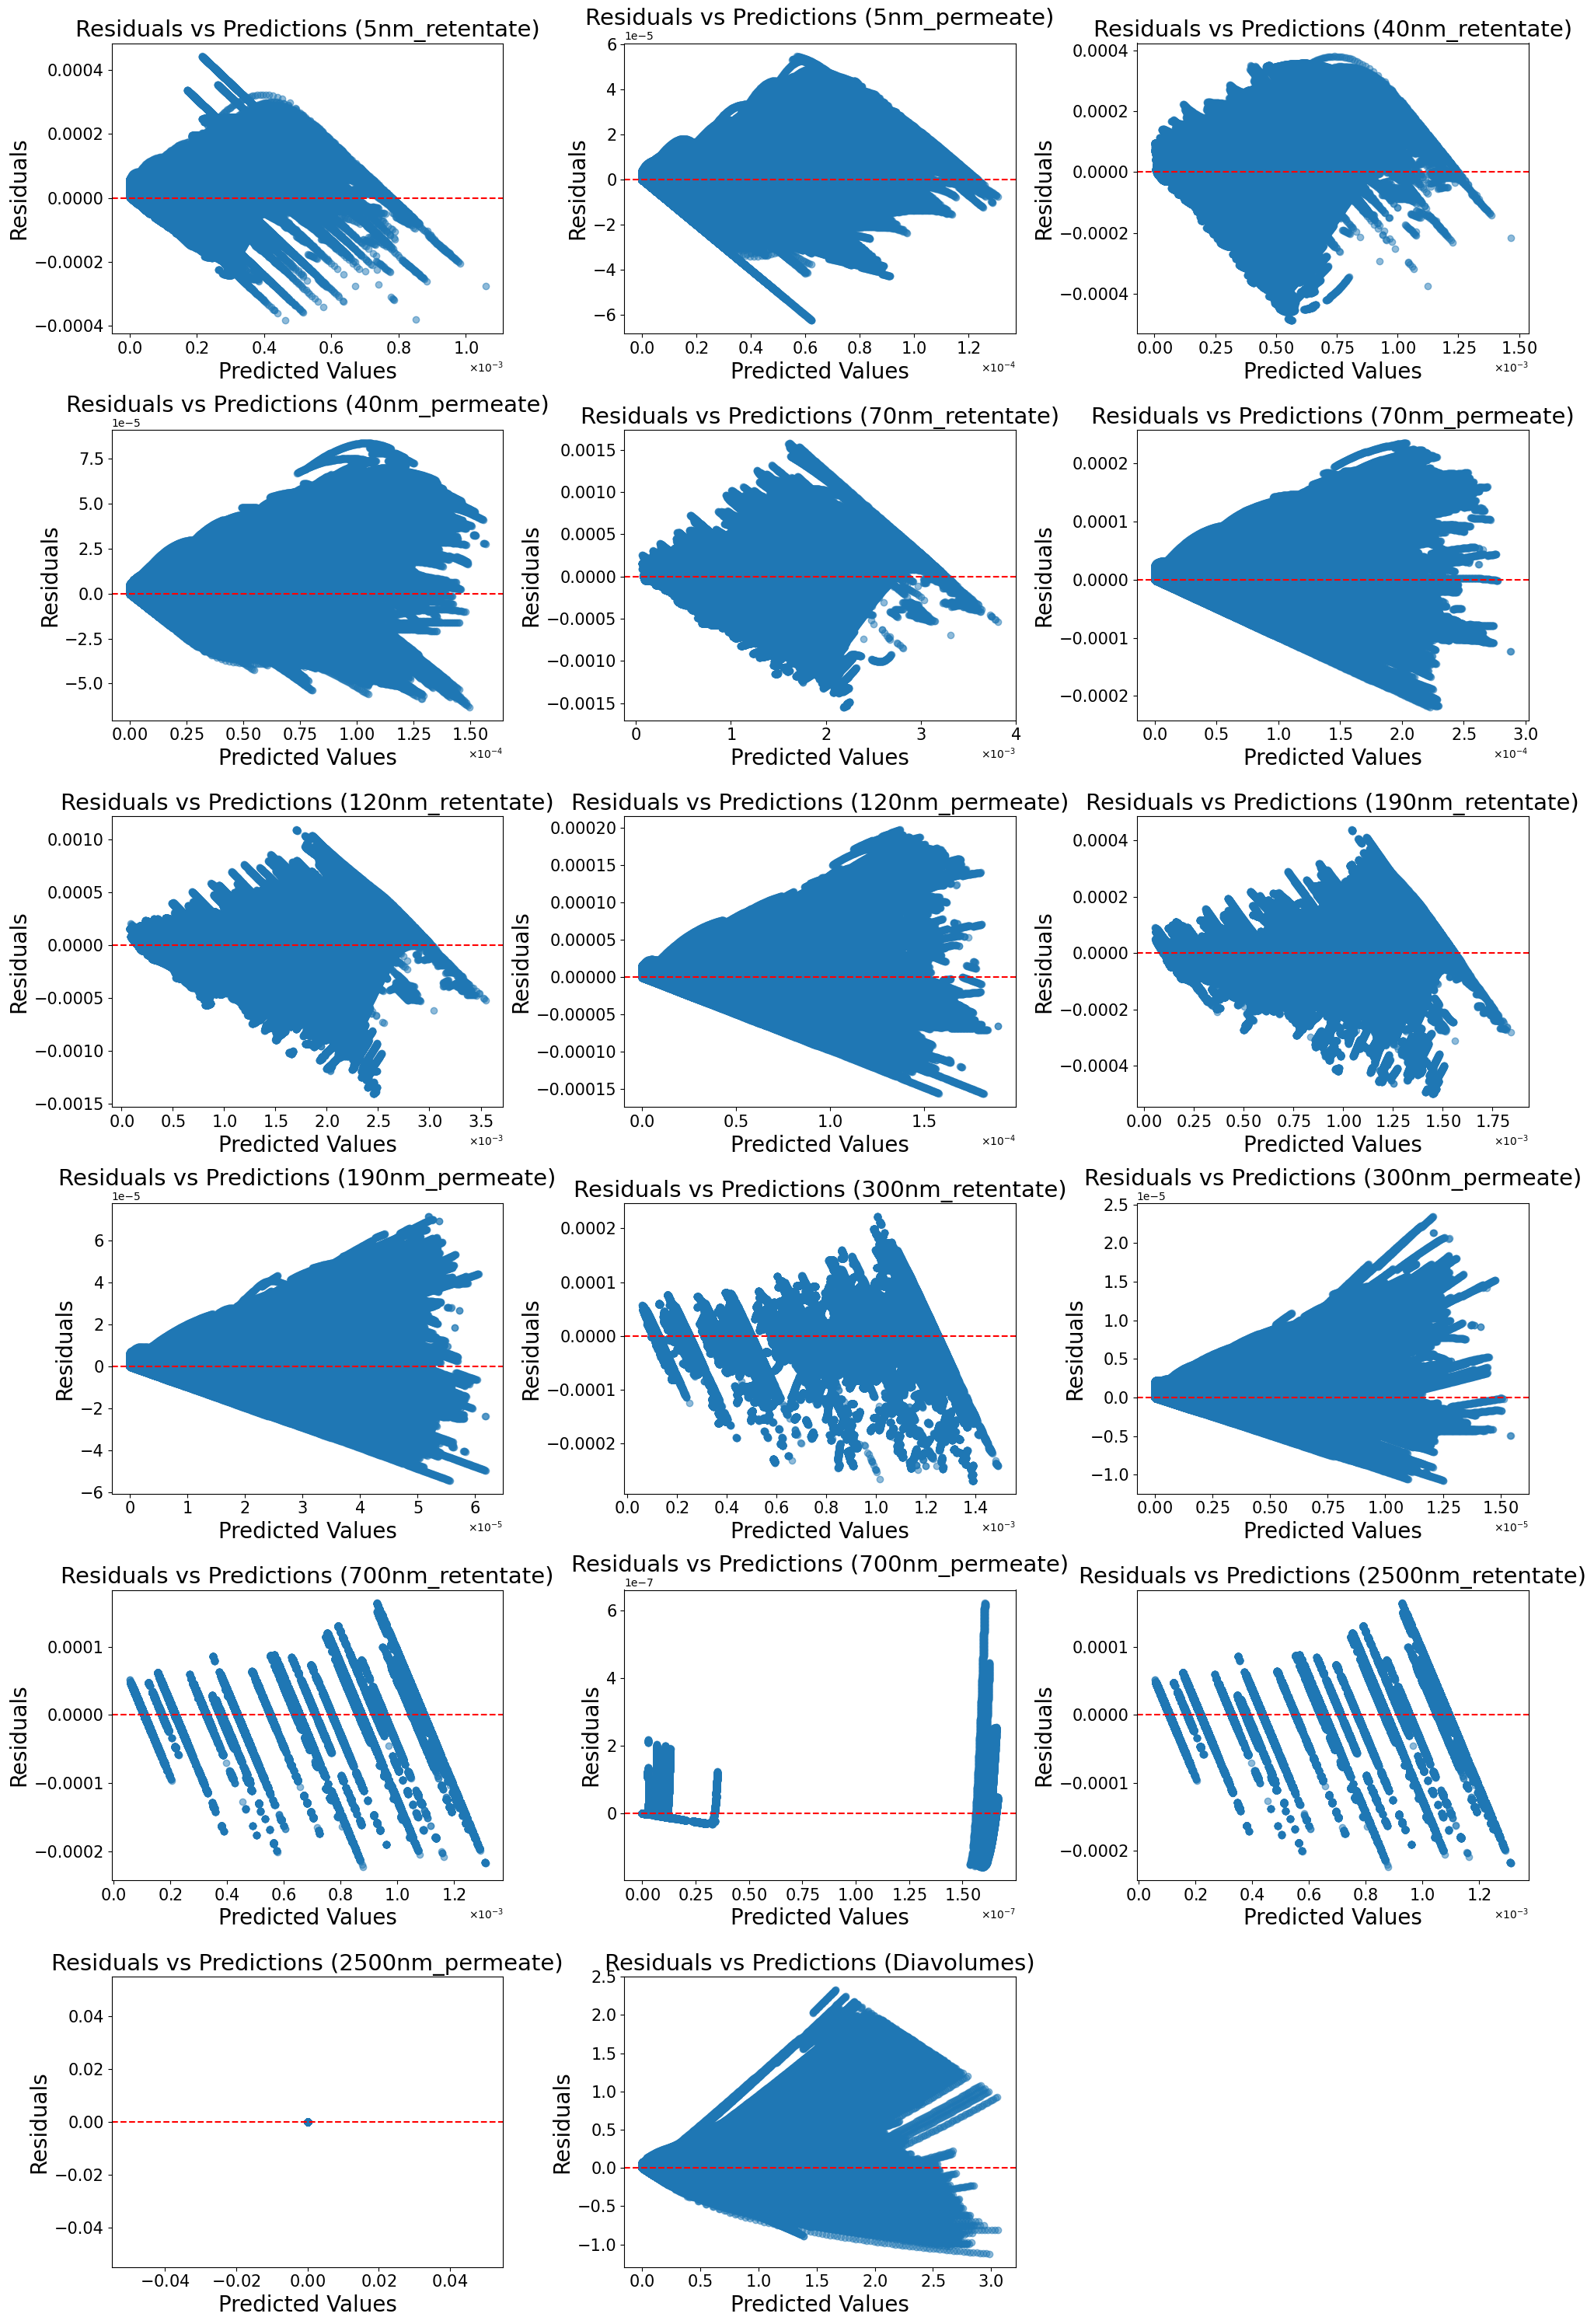

In [33]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
residuals = Y_test-Y_test_pred
residuals = pd.DataFrame(residuals, columns=Y.columns)

# Number of targets
num_targets = residuals.shape[1]

# Create subplots
fig, axes = plt.subplots(nrows=(num_targets // 3) + (1 if num_targets % 3 > 0 else 0), ncols=3, figsize=(20, 5 * ((num_targets // 3) + (1 if num_targets % 3 > 0 else 0))))
axes = axes.flatten()

# Plot residuals vs predicted values for each target
for i, column in enumerate(residuals.columns):
    axes[i].scatter(Y_test_pred[:, i], residuals[column], alpha=0.5)
    axes[i].axhline(y=0, color='r', linestyle='--')
    axes[i].set_title(f'Residuals vs Predictions ({column})',fontsize=21)
    axes[i].set_xlabel('Predicted Values',fontsize=20)
    axes[i].set_ylabel('Residuals',fontsize = 20)
  
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_powerlimits((-3, 3))  # Automatically switches to scientific notation
    axes[i].xaxis.set_major_formatter(formatter)

    # Move scientific notation exponent to the axis label
    axes[i].ticklabel_format(style='sci', axis='x', scilimits=(-3, 3))
    axes[i].tick_params(axis='both', which='major', labelsize=15)

    

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

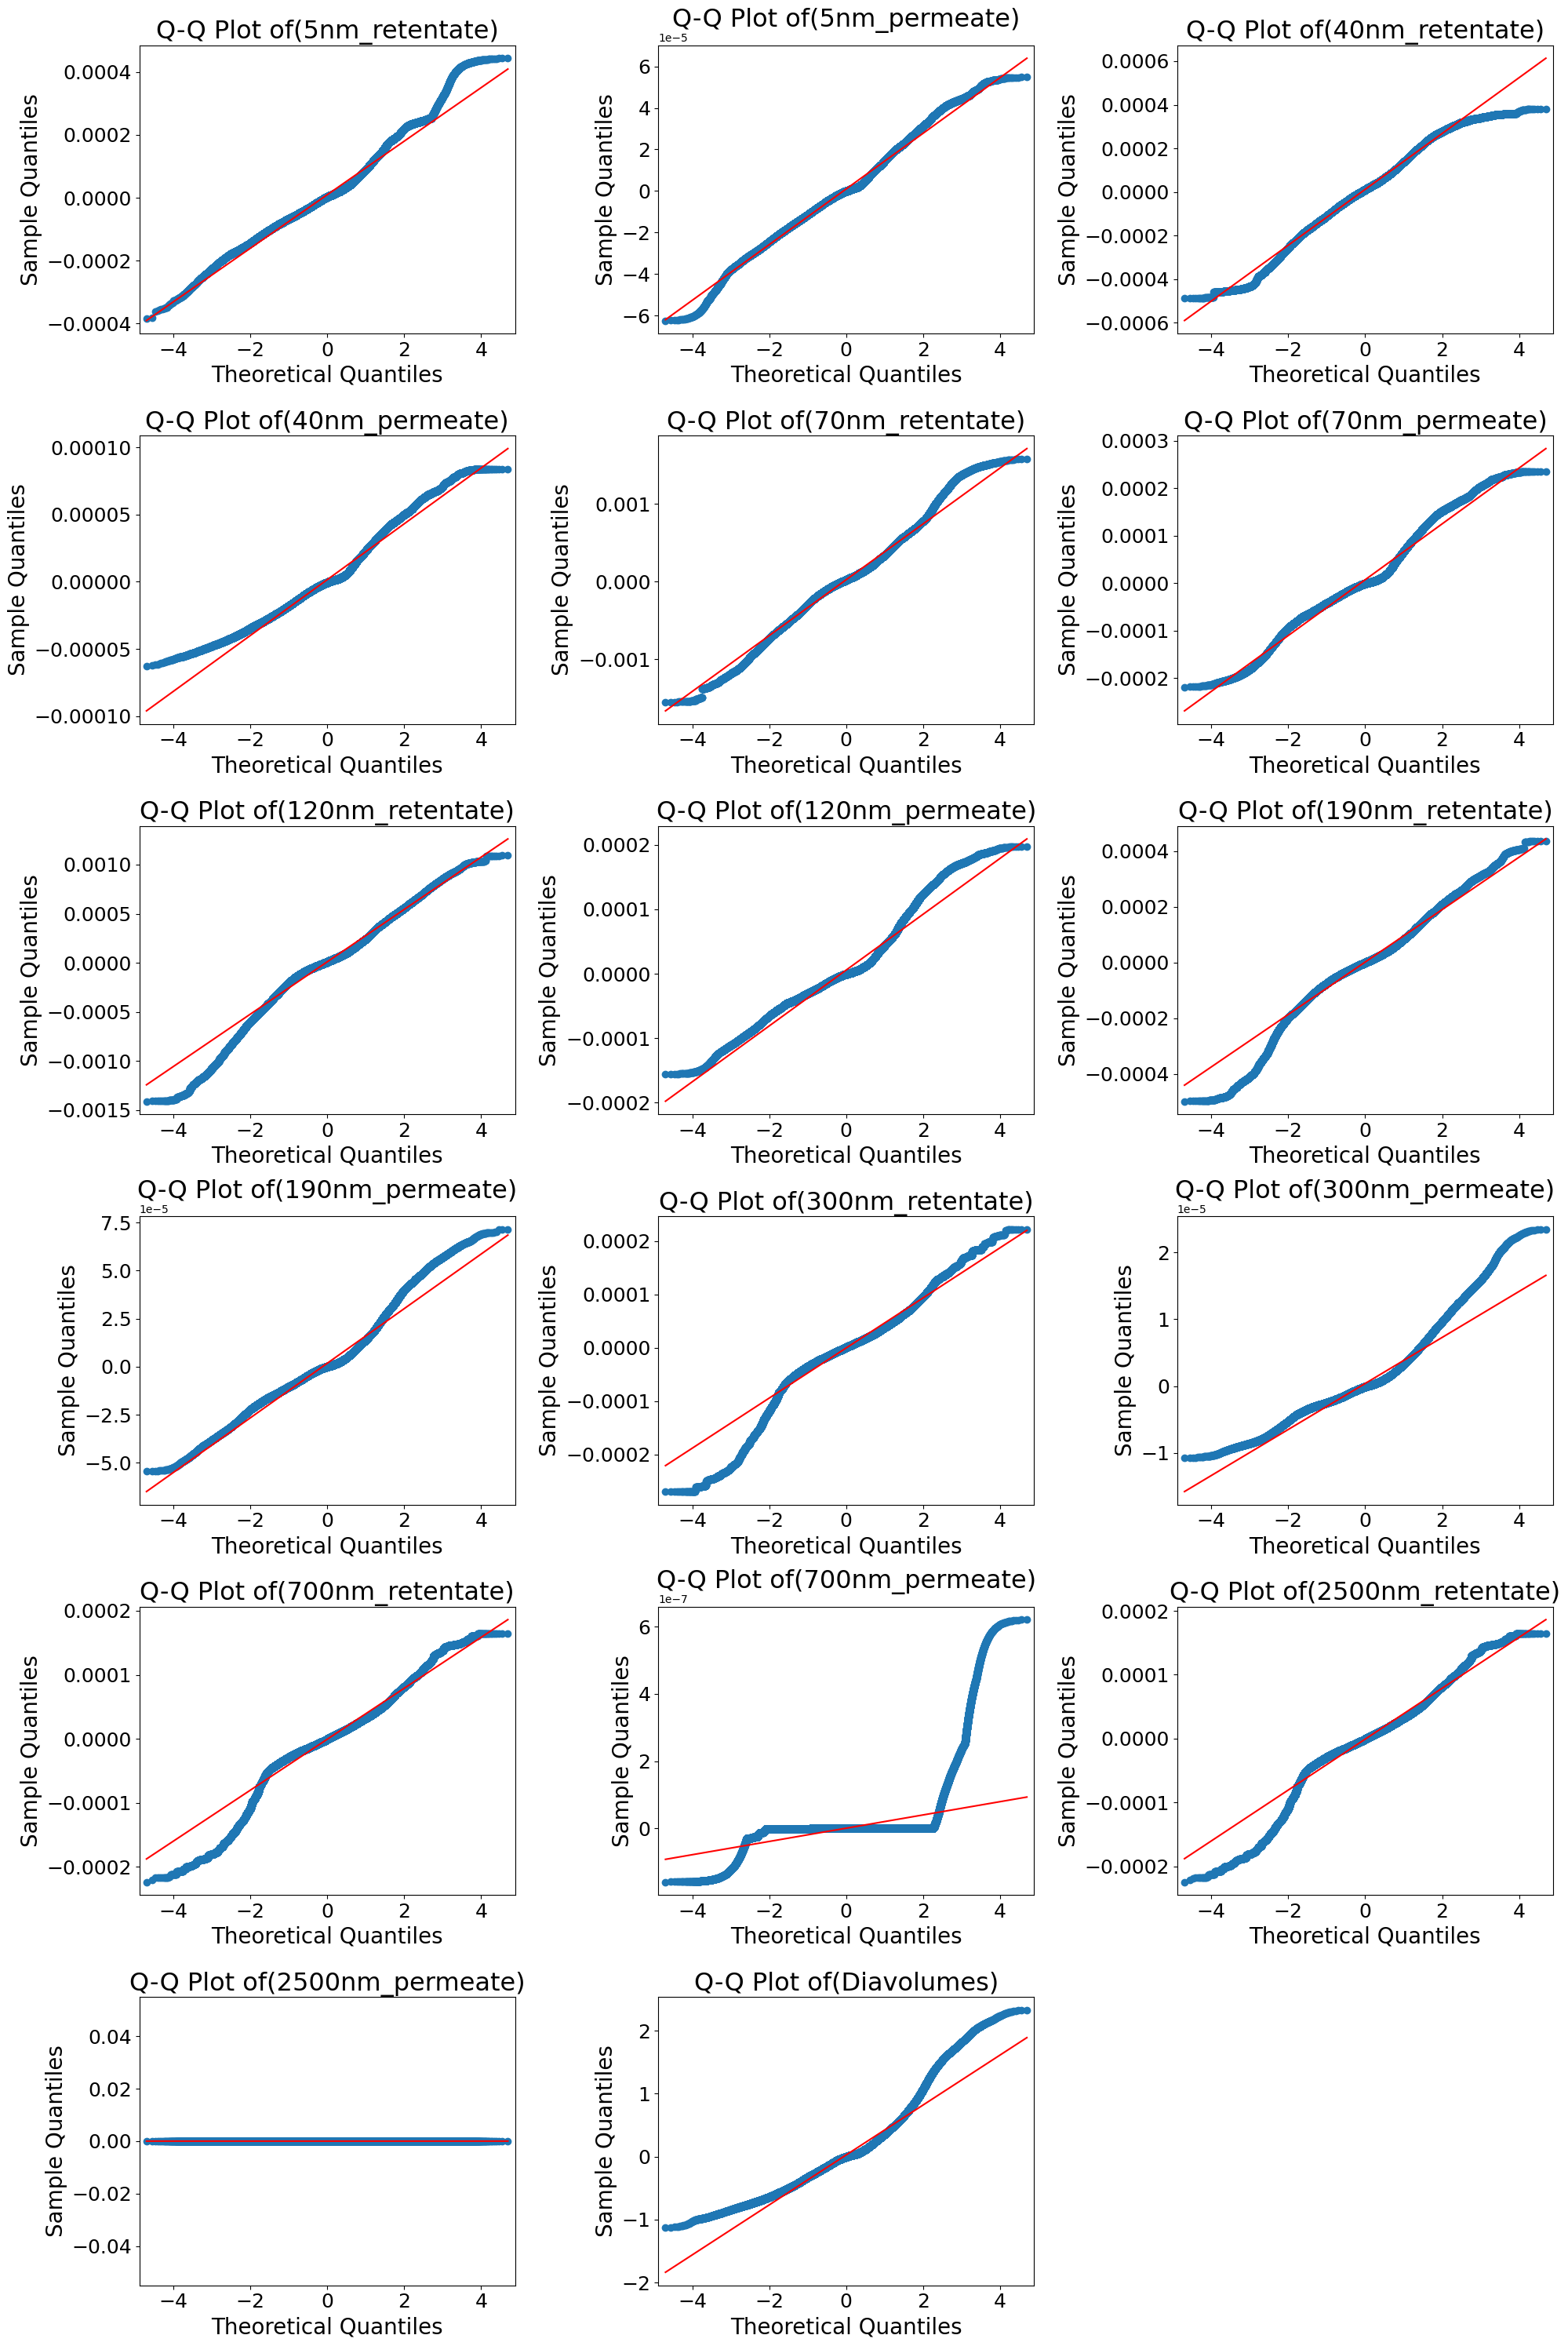

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
import pandas as pd

# Example: Replace with your actual residuals (ensure residuals is a Pandas DataFrame)
# Y_test should be a DataFrame with columns corresponding to your target variables
residuals = Y_test-Y_test_pred  # Replace Y_test with your actual residuals DataFrame
residuals = pd.DataFrame(residuals, columns=Y.columns)
# Dynamically calculate rows and columns for subplots
num_targets = residuals.shape[1]
n_rows = (num_targets // 3) + (1 if num_targets % 3 > 0 else 0)  # Adjust rows dynamically

fig, axes = plt.subplots(n_rows, 3, figsize=(20, 5 * n_rows))  # Adjust height dynamically
axes = axes.flatten()  # Flatten axes for easier iteration

# Plot Q-Q plots for each target
for i, column in enumerate(residuals.columns):
    qqplot(residuals[column], line='s', ax=axes[i])

    axes[i].set_title(f'Q-Q Plot of({column})', fontsize=23)
    axes[i].set_xlabel('Theoretical Quantiles', fontsize=20)
    axes[i].set_ylabel('Sample Quantiles', fontsize=20)
    axes[i].tick_params(axis='both', which='major', labelsize=18)
 
   

# Remove empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
